## Goal of this notebook

- verify all the DF, ADV, surface terms after we did the test_loadmasks_aste90
- do this for the BarentsS
- make sure to define the correct gates in the Barents Sea
- try again to do the gateway term so we are prepped for An meeting

In [2]:
# path for the masks is at /scratch/atnguyen/aste_90x150x60/run_template/input_maskTransport/

# IMPORTANT NOTE HERE THIS RUN ALL IS LOADING FOR ASTE 270 BUT WE LATER RESET THE GRID TO ASTE 90

# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
dirroot = "/scratch3/atnguyen/aste_90x150x60/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
runstr= "run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/"
layers_path = dirroot + runstr
extL = "LAYERS"
dirmask = dirroot + "run_template/input_maskTransport/"
dirdiags = layers_path + "diags/BUDG/"
dirstate = layers_path + "diags/STATE/"

In [4]:
# set the parameters for the aste 90 grid
nx = 90
ncut1 = 150
ncut2 = 60
ny = 2*ncut1 + nx + ncut2
nz = 50
nfx = np.array([nx,0,nx,ncut2,ncut1])
nfy = np.array([ncut1, 0, nx,nx,nx])

In [5]:
# remake hf1 here just to check

nx = 90
ncut1 = 150
ncut2 = 60
ny = 2*ncut1+nx+ncut2   # this is 450
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

mygrid = {
    'dirGrid': dirgrid,
    'nFaces': 5,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','RAC','Depth','maskInC','DXG','DYG'] #  ,'DXG','DYG','DXC','DYC'] # 'XG','YG'
fldstr3d = ['hFacC','hFacW','hFacS']#,'mskC','mskS','mskW']
fldstr3dp = ['hFacC' ,'hFacW','hFacS']#,'maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','DRF','RF'] # ,'RF','DRC',

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirgrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirgrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirgrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

# mygrid['mskC'][mygrid['mskC'] == 0] = np.nan
RAC = mygrid['RAC']
mskC = mygrid['maskInC']

In [6]:
# mygrid['hFacW']

In [7]:
hf1 = mygrid['hFacC'][0] # top layer in z
hf1.shape

(450, 90)

In [8]:
# try to use rdmds
fileprefix = "/scratch3/atnguyen/aste_90x150x60/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v2_mskBasin.bin"
ind = np.fromfile(filename, dtype=np.int32)  # auto-reads .meta for shape/dtype/order
print(ind.shape)
orig_shape = (ind.shape)


(40500,)


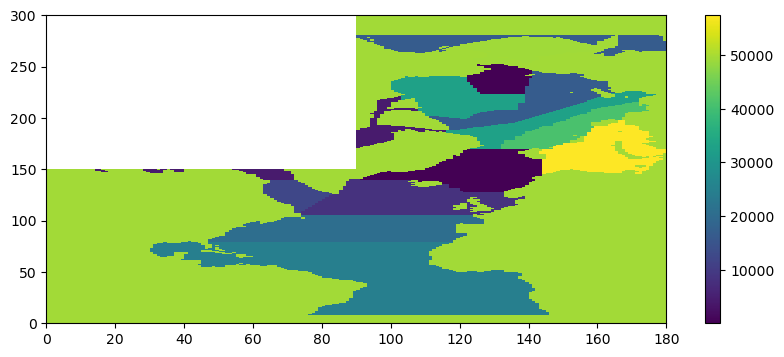

In [9]:
ind = ind.reshape(ny,nx)
plt.pcolormesh(get_aste_tracer(ind,nfx,nfy)[0])
# plt.xlim(140,180)
# plt.ylim(130,220)
plt.colorbar()

In [10]:
landmsk = np.zeros((ny,nx))
landmsk[hf1 == 0] = 1
landmsk[hf1 == 1] = np.nan

In [11]:
mymsk = np.full((ny,nx),np.nan)
mymsk[ind == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

In [12]:
# redefine the gateways here and make sure these are correct
# at y = 186, we want -ADVy
x_bsoh = np.array([54, 54, 54, 54, 54])
x_bsov = np.array([0,  1,  2,  3,  4,  5,  6,  7,  8,  9])    # from Norway to Sp
y_bsoh = np.array([145, 146, 147, 148, 149])
y_bsov = np.array([186, 186, 186, 186, 186, 186, 186, 186, 186, 186])    # from Norway to Sp

x_spfjh = np.array([20,20,20,23,24,24,26,26])    # vertical gates from Sp to Fj as -x
y_spfjh = np.array([185,184,183,182,181,180,179,178])
x_spfjv = np.array([20,21,22,23,24,25,26])          # horizontal gates where we want to read -y
y_spfjv = np.array([183,183,183,183,182,180,180])

y_fjnzv = np.arange(165,175,1)
x_fjnzv = np.full_like(y_fjnzv,27)    # horizontal gate where we want to read -x

y_nzruv = np.arange(152,155,1)
x_nzruv = np.full_like(y_nzruv,12)   # horizontal gate where we want to read -x


In [13]:
# gates_mask starts as NaN everywhere
gates_mask = np.full((ny, nx), np.nan, dtype=float)

def _mark_points(mask, xs, ys, code, ny, nx, name="gate"):
    """
    Mark (y, x) points in mask with 'code'.
    If a point already has a different non-NaN code, set it to 3 (overlap).
    Bounds are clipped to the grid silently.
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if xs.shape != ys.shape:
        raise ValueError(f"{name}: x/y length mismatch: {xs.shape} vs {ys.shape}")

    # clip to valid indices just in case
    xi = np.clip(xs.astype(int), 0, nx-1)
    yi = np.clip(ys.astype(int), 0, ny-1)

    for j, i in zip(yi, xi):
        cur = mask[j, i]
        if np.isnan(cur):
            mask[j, i] = code
        elif cur == code or cur == 3:
            # already same code or already overlap — leave as is
            continue
        else:
            mask[j, i] = 3  # overlap with different code
    return mask

# ---- mark H gates with code = 1 ----
gates_mask = _mark_points(gates_mask, x_bsoh, y_bsoh, 1, ny, nx, name="bsoh")
gates_mask = _mark_points(gates_mask, x_spfjh, y_spfjh, 1, ny, nx, name="spfjh")

# ---- mark V gates with code = 2 ----
gates_mask = _mark_points(gates_mask, x_bsov,  y_bsov,  2, ny, nx, name="bsov")
gates_mask = _mark_points(gates_mask, x_spfjv, y_spfjv, 2, ny, nx, name="spfjv")
gates_mask = _mark_points(gates_mask, x_fjnzv, y_fjnzv, 2, ny, nx, name="fjnzv")
gates_mask = _mark_points(gates_mask, x_nzruv, y_nzruv, 2, ny, nx, name="nzruv")

# Optional: if you prefer 0 instead of NaN for “not a gate”
# gates_mask = np.nan_to_num(gates_mask, nan=0.0)

In [14]:
# let's make a mask of these to double check that we did this correctly

gates_mask[182,23] = 3
gates_mask[180,24] = 3
gates_mask[180,26] = np.nan
gates_mask[182,24] = np.nan
gates_mask[183,23] = np.nan

In [15]:
mymsk_1d = mymsk.reshape(orig_shape, order='C')
mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

(140.0, 200.0)

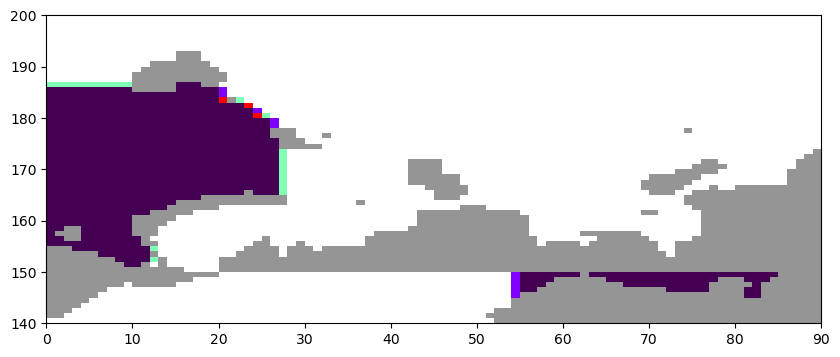

In [16]:
plt.pcolormesh(mymsk)
plt.pcolormesh(gates_mask,cmap='rainbow')
plt.pcolormesh(landmsk,cmap="Greys",vmin=-2,vmax=4)
plt.ylim(140,200)
# plt.scatter([24],[180],s=2)

(140.0, 200.0)

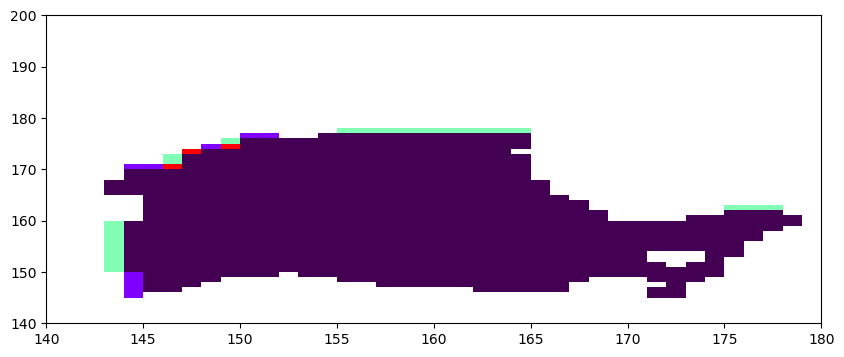

In [17]:
plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0])
plt.pcolormesh(get_aste_tracer(gates_mask,nfx,nfy)[0],cmap='rainbow')
plt.xlim(140,180)
plt.ylim(140,200)

In [28]:
# we need to also create the theta and salt bins for this area

# 'diags/state_3d_set1'
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(dirstate + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx) #* hf
SALT = SALT.reshape(nz,ny,nx)

In [38]:
filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

In [39]:
print(binwidthT1)

[0.39999998 0.40000004 0.30000001 0.30000001 0.39999998 0.4
 0.40000001 0.40000001 0.4        0.30000001 0.30000001 0.39999998
 0.40000004 0.39999998 0.39999998 0.39999998 0.29999995 0.29999995
 0.39999998 0.4000001  0.4000001  0.4000001  0.39999986 0.29999995
 0.30000019 0.39999986 0.39999986 0.4000001  0.39999986 0.4000001
 0.30000019 0.29999971 0.4000001  0.4000001  0.4000001  0.4000001
 0.39999962 0.30000019 0.30000019 0.39999962 0.4000001  0.4000001
 0.4000001  0.4000001  0.29999971 0.30000019 0.4000001  0.39999962
 0.4000001  0.40000057 0.4000001  0.29999924 0.30000019 0.40000057
 0.39999962 0.39999962 0.39999962 0.40000057 0.30000019 0.29999924
 0.40000057 0.40000057 0.39999962 0.39999962 0.39999962 0.30000019
 0.30000019 0.39999962 0.40000057 0.40000057 0.39999962 0.39999962
 0.30000019 0.30000019 0.39999962 0.39999962 0.40000057 0.40000057
 0.39999962 0.30000019 0.30000019 0.39999962 0.39999962 0.39999962
 0.40000057 0.40000057 0.29999924 0.30000019 0.40000057 0.39999962
 0.39

In [40]:
# TH
filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
boundsT = np.squeeze(boundsT).ravel()  # like squeeze(...)' -> 1D
nT = boundsT.shape[0] - 1

binwidthT = boundsT[1:] - boundsT[:-1]              # bbb.binwidthT
binmidT   = 0.5 * (boundsT[1:] + boundsT[:-1])      # bbb.binmidT
binwidthT1 = 0.5 * (binwidthT[1:] + binwidthT[:-1]) # bbb.binwidthT1

# SLT
filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
boundsS = np.squeeze(boundsS).ravel()
nS = boundsS.shape[0] - 1

binwidthS = boundsS[1:] - boundsS[:-1]
binmidS   = 0.5 * (boundsS[1:] + boundsS[:-1])
binwidthS1 = 0.5 * (binwidthS[1:] + binwidthS[:-1])

nTm1 = nT - 1
nSm1 = nS - 1

In [44]:
# get the volume transport in those gates

tsstr = np.array(['0000000002','0000000003'])
t2 = int(tsstr[0])
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","ADVx_SLT","ADVy_SLT",])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

ADVx_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[2])
ADVy_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[3])

In [45]:
ADVx_TH = ADVx_TH.reshape((nz,ny,nx))
ADVy_TH = ADVy_TH.reshape((nz,ny,nx))
ADVx_SLT = ADVx_SLT.reshape((nz,ny,nx))
ADVy_SLT = ADVy_SLT.reshape((nz,ny,nx))

x_bsoh
y_bsoh

ADV_west = np.zeros((nz,ny,nx))
for j,i, in zip(y_bsoh,x_bsoh):
    ADV_west[:,j,i] += ADVx_TH[:,j,i]       # + into basin
for j,i, in zip(y_bsov,x_bsov):
    ADV_west[:,j-1,i] -= ADVy_TH[:,j,i]

ADV_westSLT = np.zeros((nz,ny,nx))
for j,i, in zip(y_bsoh,x_bsoh):
    ADV_westSLT[:,j,i] += ADVx_SLT[:,j,i]       # + into basin
for j,i, in zip(y_bsov,x_bsov):
    ADV_westSLT[:,j-1,i] -= ADVy_SLT[:,j,i]
# this is now in degC.m^3/s

# THETA_gate = np.zeros((nz,ny,nx))
# for j,i, in zip(y_bsoh,x_bsoh):
#     THETA_gate[:,j,i] = THETA[:,j,i]       # + into basin
# for j,i, in zip(y_bsov,x_bsov):
#     THETA_gate[:,j-1,i] = THETA[:,j-1,i]


In [46]:
# THETA: (nz, ny, nx) at cell centers (T grid)
# (y_bsoh, x_bsoh): indices of U-faces (east-west faces; normal in +x)
# (y_bsov, x_bsov): indices of V-faces (north-south faces; normal in +y)

THETA_face = np.zeros_like(THETA)

# ---- U-faces (collocated with UVEL[j, i]): average in i-direction ----
for j, i in zip(y_bsoh, x_bsoh):
    if i > 0:
        # face between (j, i-1) and (j, i)
        THETA_face[:, j, i] = 0.5 * (THETA[:, j, i] + THETA[:, j, i-1])

# ---- V-faces (collocated with VVEL[j, i]): average in j-direction ----
for j, i in zip(y_bsov, x_bsov):
    if j > 0:
        # face between (j-1, i) and (j, i)
        THETA_face[:, j-1, i] = 0.5 * (THETA[:, j, i] + THETA[:, j-1, i])


SALT_face = np.zeros_like(SALT)

# ---- U-faces (collocated with UVEL[j, i]): average in i-direction ----
for j, i in zip(y_bsoh, x_bsoh):
    if i > 0:
        # face between (j, i-1) and (j, i)
        SALT_face[:, j, i] = 0.5 * (SALT[:, j, i] + SALT[:, j, i-1])

# ---- V-faces (collocated with VVEL[j, i]): average in j-direction ----
for j, i in zip(y_bsov, x_bsov):
    if j > 0:
        # face between (j-1, i) and (j, i)
        SALT_face[:, j-1, i] = 0.5 * (SALT[:, j, i] + SALT[:, j-1, i])


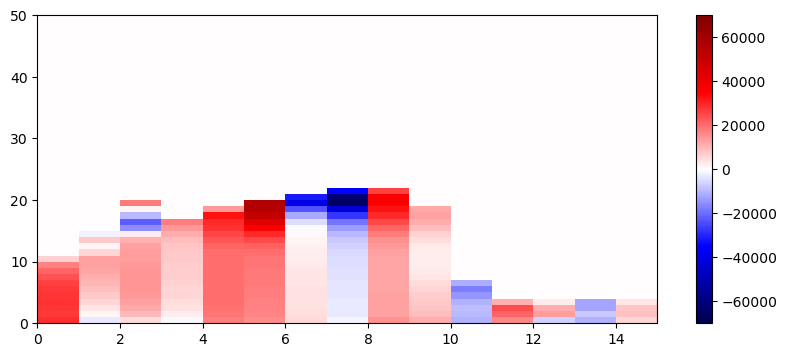

In [47]:
jj,ii = np.where(THETA_face[0] != 0)[0],np.where(THETA_face[0] != 0)[1]

fig = plt.figure()
ax = plt.subplot(111)
cb = ax.pcolormesh(VEL_west[:,jj,ii],cmap='seismic',vmin=-7e4,vmax=7e4)
plt.colorbar(cb)

# ax = plt.subplot(132)
# cb = ax.pcolormesh(ADV_west[:,jj,ii],cmap='seismic')
# plt.colorbar(cb)

# ax = plt.subplot(133)
# cb = ax.pcolormesh(THETA_face[:,jj,ii] * VEL_west[:,jj,ii] - ADV_west[:,jj,ii],cmap='seismic')
# plt.colorbar(cb)

In [48]:
np.nansum(VEL_west[:,jj,ii]) - 1701560.6270304453


-2.3283064365386963e-10

In [49]:
# create the volume and bin this
DXG3d = np.tile(mygrid['DXG'][np.newaxis,:,:],(nz,1,1))
DYG3d = np.tile(mygrid['DYG'][np.newaxis,:,:],(nz,1,1))
DRF3d = np.tile(mygrid['DRF'][:,np.newaxis,np.newaxis],(1,ny,nx))

# grab the UVEL and VVEL for this timestep
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
VVELMASS,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])  # m/s
UVELMASS = UVELMASS.reshape(nz,ny,nx)
VVELMASS = VVELMASS.reshape(nz,ny,nx)


# create the same gateways as we do below with UVELMASS and VVELMASS
VEL_gates = {}

VEL_west = np.zeros((nz,ny,nx))
for j,i, in zip(y_bsoh,x_bsoh):
    VEL_west[:,j,i] += UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
for j,i, in zip(y_bsov,x_bsov):
    VEL_west[:,j-1,i] -= VVELMASS[:,j,i] * DXG3d[:,j,i] * DRF3d[:,j,i]

In [50]:
def bin_dF_by_theta(THETA, boundsT, DFh, DFr):
    """
    Replicates the MATLAB loop:
      for i=1:nT
        ij = find(T >= boundsT(i) & T < boundsT(i+1));
        Lij(i)        = length(ij);
        dF_Tcenter(2,i) = sum(DFh(ij));   % degC m^3/s
        dF_Tcenter(3,i) = sum(DFr(ij));   % degC m^3/s
      end
    but using THETA (3D) instead of T, and handling NaNs like MATLAB:
    if any DFh/DFr in a bin are NaN, the sum for that bin is NaN.

    Parameters
    ----------
    THETA  : ndarray (3D or any shape) — binning variable, may contain NaNs
    boundsT: (N+1,)  array of bin edges
    DFh    : ndarray same shape as THETA (degC m^3/s), may contain NaNs
    DFr    : ndarray same shape as THETA (degC m^3/s), may contain NaNs

    Returns
    -------
    Lij      : (N,) int    counts per bin (based on THETA only)
    dFh_bin  : (N,) float  sum of DFh in each bin (NaN if any DFh in bin is NaN)
    DFr_bin  : (N,) float  sum of DFr in each bin (NaN if any DFr in bin is NaN)
    """
    THETA   = np.asarray(THETA)
    boundsT = np.asarray(boundsT)
    DFh     = np.asarray(DFh)
    DFr     = np.asarray(DFr)

    nT = boundsT.size - 1

    # Flatten for vectorized binning
    theta = THETA.ravel()
    dfh   = DFh.ravel()
    dfr   = DFr.ravel()

    # Bin indices for [lower, upper) using np.digitize(..., right=False)
    bin_idx = np.digitize(theta, boundsT, right=False) - 1

    # Valid THETA: finite and within bin range
    valid_theta = np.isfinite(theta) & (bin_idx >= 0) & (bin_idx < nT)
    idx = bin_idx[valid_theta]

    # Lij = count of THETA in each bin (regardless of DFh/DFr NaNs)
    Lij = np.bincount(idx, minlength=nT)

    # ----- DFh sums with MATLAB-like NaN propagation -----
    vals_h = dfh[valid_theta]
    nan_h  = np.isnan(vals_h)

    # Sum the non-NaN values
    sum_h = np.bincount(idx[~nan_h], weights=vals_h[~nan_h], minlength=nT).astype(float)

    # If any NaN occurred in a bin, set that bin's sum to NaN
    any_nan_h = np.bincount(idx[nan_h], minlength=nT) > 0
    sum_h[any_nan_h] = np.nan
    dFh_bin = sum_h

    # ----- DFr sums with MATLAB-like NaN propagation -----
    vals_r = dfr[valid_theta]
    nan_r  = np.isnan(vals_r)

    sum_r = np.bincount(idx[~nan_r], weights=vals_r[~nan_r], minlength=nT).astype(float)
    any_nan_r = np.bincount(idx[nan_r], minlength=nT) > 0
    sum_r[any_nan_r] = np.nan
    DFr_bin = sum_r

    return Lij, dFh_bin

In [51]:
# we want to bin this to T space

Lij, adv_hconv_binned = bin_dF_by_theta(THETA_face, boundsT.flatten(), ADV_west,ADV_west)
Lij, vel_binned = bin_dF_by_theta(THETA_face, boundsT.flatten(), VEL_west,VEL_west)    #m^3/s


Lij, adv_hconv_binned2 = bin_dF_by_theta(THETA_face, boundsT.flatten(), ADV_west/THETA_face,ADV_west/THETA_face)

Lij, adv_hconv_binned3 = bin_dF_by_theta(SALT_face, boundsT.flatten(), ADV_westSLT/SALT_face,ADV_westSLT/SALT_face)


vel_edge = 0.5 * (vel_binned[:-1] + vel_binned[1:])

adv_edge = 0.5 * (adv_hconv_binned2[:-1] + adv_hconv_binned2[1:])
adv_edgeS = 0.5 * (adv_hconv_binned3[:-1] + adv_hconv_binned3[1:])


ADV_TedgeW  = 0.5 * (adv_hconv_binned[:-1] + adv_hconv_binned[1:])
G_T_offlineW = ADV_TedgeW / binwidthT1

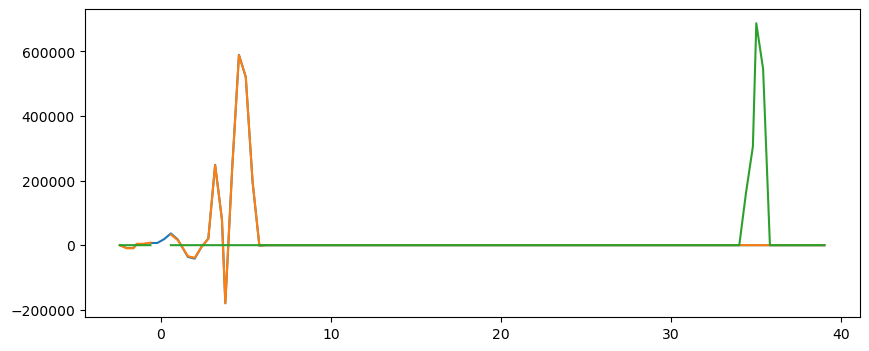

In [52]:
fig = plt.figure()

ax = plt.subplot(111)

# ax.plot(boundsT.flatten()[1:-1],G_T_offlineW)
ax.plot(boundsT.flatten()[1:-1],vel_edge)
ax.plot(boundsT.flatten()[1:-1],adv_edge)
ax.plot(boundsT.flatten()[1:-1],adv_edgeS)

In [53]:
print(np.nansum(vel_edge))
print(np.nansum(ADV_west/THETA_face))
print(np.nansum(G_T_offlineW))

1701560.627030445
1698853.62464872
19264846.964237854


In [54]:
# Shapes & inputs:
# THETA:   (nz, ny, nx) cell centers
# UVELMASS (m/s) on west/east faces, VVELMASS (m/s) on south/north faces
# ADVx_TH, ADVy_TH: advective theta flux diagnostics on faces [degC * m^3/s]
# Grid: DXG(j,i), DYG(j,i), DRF(k), hFacW(k,j,i), hFacS(k,j,i)
# Gate face index lists: (y_bsoh, x_bsoh) for U-faces, (y_bsov, x_bsov) for V-faces
# boundsT: theta-bin edges (1D), binwidthT1: Δθ at edges (same length as boundsT-1)

# --- 0) Reshape faces if needed ---
ADVx_TH = ADVx_TH.reshape((nz, ny, nx))
ADVy_TH = ADVy_TH.reshape((nz, ny, nx))
UVELMASS = UVELMASS.reshape((nz, ny, nx))
VVELMASS = VVELMASS.reshape((nz, ny, nx))

# --- 1) 3D metrics & partial cells ---
DXG3d  = mygrid['DXG'][None, :, :].repeat(nz, axis=0)
DYG3d  = mygrid['DYG'][None, :, :].repeat(nz, axis=0)
DRF3d  = mygrid['DRF'][:, None, None].repeat(ny, axis=1).repeat(nx, axis=2)

# IMPORTANT: include hFacW / hFacS
A_W = DYG3d * DRF3d * mygrid['hFacW']  # area of west/east faces
A_S = DXG3d * DRF3d * mygrid['hFacS']  # area of south/north faces

# --- 2) Build transports on the gate, keeping U and V separate ---
Q_U = np.zeros((nz, ny, nx))  # m^3/s on U-faces (only gate faces filled)
Q_V = np.zeros((nz, ny, nx))  # m^3/s on V-faces (only gate faces filled)

# Define your "into basin" sign for each gate segment.
# For a west/east-oriented segment using U, we'll say + is into basin as you had.
for j, i in zip(y_bsoh, x_bsoh):
    Q_U[:, j, i] += UVELMASS[:, j, i] * A_W[:, j, i]  # + into basin

# For a north/south-oriented segment using V, you had "minus" and mapped to (j-1,i).
# Keep the same mapping/sign so ADV and Q are consistent.
for j, i in zip(y_bsov, x_bsov):
    Q_V[:, j-1, i] -= VVELMASS[:, j, i] * A_S[:, j, i]

# --- 3) Upwind θ at the actual faces (U and V handled separately) ---
theta_U = np.zeros_like(Q_U)
theta_V = np.zeros_like(Q_V)

# U-faces lie between i-1 and i:
theta_U[:, :, 1:] = np.where(Q_U[:, :, 1:] > 0.0,
                             THETA[:, :, :-1],  # flow to +x: upstream left
                             THETA[:, :, 1:])   # flow to -x: upstream right
theta_U[:, :, 0]  = THETA[:, :, 0]  # boundary fallback

# V-faces lie between j-1 and j (but your gate stores them at (j-1,i)):
Q_V_face = np.zeros_like(Q_V)
Q_V_face[:, 1:, :] = Q_V[:, 1:, :]  # these entries correspond to faces between (j-1,*) and (j,*)

theta_V[:, 1:, :] = np.where(Q_V_face[:, 1:, :] > 0.0,
                             THETA[:, :-1, :],  # flow to +y: upstream is lower cell (j-1)
                             THETA[:, 1:, :])   # flow to -y: upstream is upper cell (j)
theta_V[:, 0, :]  = THETA[:, 0, :]  # boundary fallback

# --- 4) Reconstructed advective heat flux on gate faces ---
F_U = theta_U * Q_U               # degC * m^3/s
F_V = theta_V * Q_V               # degC * m^3/s

# --- 5) Make ADV gate with identical sign/mapping as Q gate ---
ADV_gate = np.zeros((nz, ny, nx))
for j, i in zip(y_bsoh, x_bsoh):
    ADV_gate[:, j, i] += ADVx_TH[:, j, i]          # + into basin
for j, i in zip(y_bsov, x_bsov):
    ADV_gate[:, j-1, i] -= ADVy_TH[:, j, i]        # match the transport sign & placement

# --- 6) TS binning: bin U and V contributions separately, then sum ---
# We bin by the *face* θ we actually used to form the flux/transport.
Lij, Fbin_U = bin_dF_by_theta(theta_U, boundsT.flatten(), F_U, F_U)
Lij, Fbin_V = bin_dF_by_theta(theta_V, boundsT.flatten(), F_V, F_V)
Fbin = Fbin_U + Fbin_V

Lij, Qbin_U = bin_dF_by_theta(theta_U, boundsT.flatten(), Q_U, Q_U)
Lij, Qbin_V = bin_dF_by_theta(theta_V, boundsT.flatten(), Q_V, Q_V)
Qbin = Qbin_U + Qbin_V

# For "edge" representation in θ (optional, if your later code expects edges):
F_edge = 0.5 * (Fbin[:-1] + Fbin[1:])
Q_edge = 0.5 * (Qbin[:-1] + Qbin[1:])

# Offline G_T from faces:
G_T_offline = F_edge / binwidthT1


In [55]:
# Gate totals should match (up to roundoff and limiter differences):
Q_direct  = np.nansum(Q_U) + np.nansum(Q_V)
Q_from_TS = np.nansum(Qbin)
print("Volume match (TS vs direct):", Q_from_TS, Q_direct)

F_direct  = np.nansum(F_U) + np.nansum(F_V)
F_from_TS = np.nansum(Fbin)
print("Heat (θ·Q) match (TS vs direct):", F_from_TS, F_direct)

print("Diag vs recon (sum over gate faces):",
      np.nansum(ADV_gate), np.nansum(F_U + F_V))

print(np.nansum(G_T_offline))

Volume match (TS vs direct): 1690358.991425681 1690358.9914256814
Heat (θ·Q) match (TS vs direct): 7795646.088775906 7795646.088775904
Diag vs recon (sum over gate faces): 7848030.275728327 7795646.088775905
19264660.11028737


NameError: name 'G_T_volume_from_ADV' is not defined

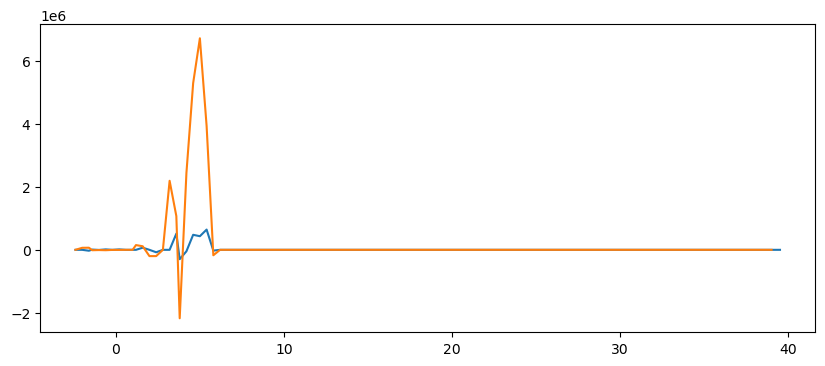

In [56]:
plt.plot(boundsT.flatten()[1:],Qbin,label='theta*Velmass transport  m^3/s')
plt.plot(boundsT.flatten()[1:-1],G_T_offline)

plt.plot(boundsT.flatten()[1:-1],G_T_volume_from_ADV)

In [ ]:
np.nansum(G_T_volume_from_ADV)

In [57]:
# Inputs:
# THETA:   (nz, ny, nx) at T-points (°C)
# ADVx_TH: (nz, ny, nx) °C·m³/s on U-faces, ADVy_TH: (nz, ny, nx) °C·m³/s on V-faces
# Gate faces: (y_bsoh, x_bsoh) for U-faces; (y_bsov, x_bsov) for V-faces
# boundsT (bin edges), binwidthT1 (Δθ per edge)

epsT = 1e-6  # avoid division by ~0 °C

# --- 1) Build upwind θ at the actual faces (same as advection uses) ---
theta_U = np.zeros_like(ADVx_TH)  # U-faces sit between i-1 and i
theta_U[:, :, 1:] = np.where(ADVx_TH[:, :, 1:] >= 0.0,
                             THETA[:, :, :-1],        # upstream left if flux is into +x
                             THETA[:, :, 1:])         # upstream right if flux is into -x
theta_U[:, :, 0]  = THETA[:, :, 0]

theta_V = np.zeros_like(ADVy_TH)  # V-faces sit between j-1 and j
theta_V[:, 1:, :] = np.where(ADVy_TH[:, 1:, :] >= 0.0,
                             THETA[:, :-1, :],        # upstream lower cell if flux into +y
                             THETA[:, 1:, :])         # upstream upper cell if flux into -y
theta_V[:, 0, :]  = THETA[:, 0, :]

# --- 2) Recover volume transport from ADV (per face) ---
# Q = (θ·Q)/θ = ADV / θ_face  (mask tiny θ to avoid blow-ups)
Q_from_ADV_U = np.where(np.abs(theta_U) > epsT, ADVx_TH / theta_U, 0.0)  # m³/s on U-faces
Q_from_ADV_V = np.where(np.abs(theta_V) > epsT, ADVy_TH / theta_V, 0.0)  # m³/s on V-faces

# --- 3) Map to your gate stencil with your sign convention (match what you used before) ---
Q_gate = np.zeros_like(THETA)

# U segments: + into basin at (j,i)
for j, i in zip(y_bsoh, x_bsoh):
    Q_gate[:, j, i] += Q_from_ADV_U[:, j, i]

# V segments: you place them at (j-1,i) with a minus sign (into basin).
for j, i in zip(y_bsov, x_bsov):
    Q_gate[:, j-1, i] -= Q_from_ADV_V[:, j, i]

# For completeness, also assemble the corresponding face θ used for binning:
theta_gate = np.zeros_like(THETA)
for j, i in zip(y_bsoh, x_bsoh):
    theta_gate[:, j, i] = theta_U[:, j, i]
for j, i in zip(y_bsov, x_bsov):
    theta_gate[:, j-1, i] = theta_V[:, j, i]

# --- 4) TS binning of *volume transport recovered from ADV* ---
# Bin by the same face θ we used to divide
Lij, Qbin_from_ADV = bin_dF_by_theta(theta_gate, boundsT.flatten(),
                                     Q_gate, Q_gate)

# Optional θ-edge representation and G_T(volume):
Q_edge_from_ADV = 0.5 * (Qbin_from_ADV[:-1] + Qbin_from_ADV[1:])
G_T_volume_from_ADV = Q_edge_from_ADV / binwidthT1


In [58]:
G_T_volume_from_ADV

array([      0.        ,    8439.40305249,  -36241.53261553,
        -35419.51036121,   26736.3654092 ,   17680.44335918,
             0.        ,       0.        ,   76404.59942077,
        101872.79480013,       0.        ,       0.        ,
        -94750.5936765 ,  -94750.60779544,   11040.46105471,
        111759.45383732,  302025.69291355,   60997.25122656,
        589734.65066362, 1181118.82653493, 1324170.746878  ,
        781035.17679671,  -31803.53407894,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,

In [59]:
THETA      = np.asarray(THETA)
ADV_west        = np.asarray(ADV_west)
boundsT    = np.asarray(boundsT.flatten())
binmidT    = np.asarray(binmidT.flatten())
binwidthT1 = np.asarray(binwidthT1.flatten())      # length nT-1

nT   = boundsT.size - 1
nTm1 = nT - 1

# x-locations for edge-based curves (length nTm1)
x = boundsT[1:-1]

# --- "new" interpretation: bin by binmidT intervals ---
theta_flat = THETA.ravel()
ADV_west_flat   = ADV_west.ravel()

ADV_west_flat /= theta_flat

# binmidT[i] <= THETA < binmidT[i+1], i=0..nT-2
bin_idx_mid = np.digitize(theta_flat, binmidT, right=False) - 1
valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(theta_flat)
idx_mid     = bin_idx_mid[valid_mid]

# per-bin sums with NaN-propagation
ADV_west_flat_new = _bincount_sum_with_nan(idx_mid, ADV_west_flat[valid_mid], nTm1)

# edge-based G (m^3/s): divide by edge binwidths
G_off_new_h = ADV_west_flat_new / binwidthT1

NameError: name '_bincount_sum_with_nan' is not defined

NameError: name 'G_off_new_h' is not defined

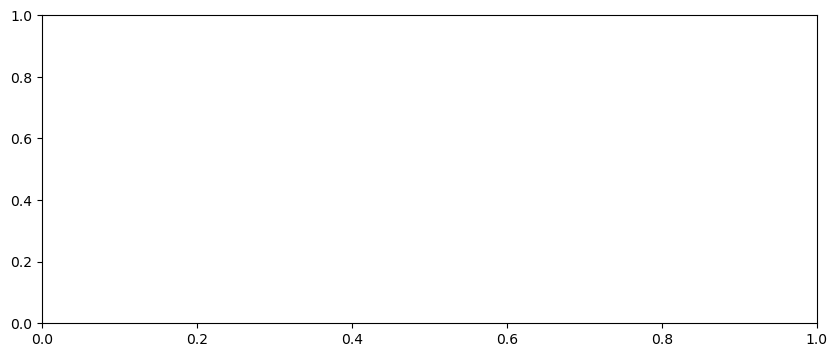

In [60]:
fig = plt.figure()

ax = plt.subplot(111)

ax.plot(boundsT.flatten()[1:-1],G_off_new_h)

In [ ]:
np.nansum(G_off_new_h)

## continue with the other G terms

In [ ]:
# Load the other terms

In [71]:
ffac=1e-6
G_T=np.array([])
metaT=parsemeta(layers_path + "diags/LAYERS/layers_3d_Ttend." + "0000000003" + ".meta")
nFldsT = metaT["fldList"]
print(len(nFldsT))
setTtend=nFldsT.copy()


# check for the correct diagnostics
metaT['fldList']   # 13, 14, 15, 16, 19, 22
b = metaT['fldList']
ifldT = np.array([1,2])    # surf, hDiff, vDiff, hADV, vADV, total tend
# print(np.array(b)[ifldT])  # for G_T

# remake the following to look for the existing terms and see if we can recreate
# ['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']
ifldT = np.array([0,1,2,7,8,11])
print(np.array(b)[ifldT])  # for G_T

24
['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']


In [72]:
layers_path

'/scratch3/atnguyen/aste_90x150x60/run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/'

In [73]:
print(boundsT.shape)
print(binsTH_edges.shape)
print(binsTH_centers.shape)

print(boundsT.flatten())
print(binsTH_edges.flatten())
print(binsTH_centers.flatten())

(113,)
(113,)
(112,)
[-2.79999995 -2.4000001  -2.         -1.60000002 -1.39999998 -1.
 -0.60000002 -0.2         0.2         0.60000002  1.          1.20000005
  1.60000002  2.          2.4000001   2.79999995  3.20000005  3.5999999
  3.79999995  4.19999981  4.5999999   5.          5.4000001   5.80000019
  6.19999981  6.4000001   6.80000019  7.19999981  7.5999999   8.
  8.39999962  8.80000019  9.          9.39999962  9.80000019 10.19999981
 10.60000038 11.         11.39999962 11.60000038 12.         12.39999962
 12.80000019 13.19999981 13.60000038 14.         14.19999981 14.60000038
 15.         15.39999962 15.80000019 16.20000076 16.60000038 16.79999924
 17.20000076 17.60000038 18.         18.39999962 18.79999924 19.20000076
 19.39999962 19.79999924 20.20000076 20.60000038 21.         21.39999962
 21.79999924 22.         22.39999962 22.79999924 23.20000076 23.60000038
 24.         24.39999962 24.60000038 25.         25.39999962 25.79999924
 26.20000076 26.60000038 27.         27.2000007

In [74]:
# 2d
rac2d = read_float64(dirgrid + "RAC" + ".data")
print("RAC2d",rac2d.shape)

drf3d = read_float32(dirgrid + "DRF" + ".data")


rac2dtile = np.tile(rac2d,(nT-1,1)) #.shape

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat

hf2dtile = np.tile(hf2d,(nT-1,1))
ffac = 1e-6

RAC2d (40500,)
(100,)


In [75]:
# we're not using iWetC2d because I'm not sure where this went for the ASTE 90 grid
ts = "0000000003"
tsstr = np.array([ts])

In [114]:
# make sure we have the correct mask based on mymsk

# load the G_T terms again with the mask in mind
# this will be a width 1 list
mymsk_1dtile = np.tile(mymsk_1d[np.newaxis,:],(nT-1,1))


# make the G_T term
G_T = {}
G_T["BarentsS"] = {}
    
# now loop through
G_T["BarentsS"][ts] = {}
for i in range(len(ifldT)-1, -1, -1):
    tmp = read_float64_skip(layers_path + "diags/LAYERS/layers_3d_Ttend." + tsstr[-1] + ".data", nx*ny*(nT-1),ifldT[i])
    tmp = np.reshape(tmp,(nT-1,nx*ny))

    # here we will want to multiply by the mask for the Barents Sea
    tmp = tmp * mymsk_1dtile * (rac2dtile * hf2dtile) #* ffac
    #tmp = tmp * (rac2dtile * hf2dtile)

    if i == ifldT.shape[0]-1:
        # if LTto2TH, do not remove from residual
        residT = tmp
    else:
        # else if vADV, hADV, vDiff, hDiff, surface, remove from residual
        residT = residT-tmp
    
    # just do the Barents Sea for this one
    a = np.nansum(tmp,axis=1)
    G_T["BarentsS"][ts][setTtend[ifldT[i]]] = a

G_T["BarentsS"][ts]["residT"] = np.nansum(residT,axis=1)

In [115]:
# just define all the terms here
# we can relist them from the previous setting
# surf, hDiff, vDiff, hADV, vADV, total tend
# ['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']
name = "BarentsS"
Gsurf = G_T[name][ts]['LaTs2TH']
GDFh  = G_T[name][ts]['LaTh2TH']
GDFr  = G_T[name][ts]['LaTz2TH']
GADVh = G_T[name][ts]['LTha2TH']
GADVr = G_T[name][ts]['LTza2TH']
Gtottend = G_T[name][ts]['LTto2TH']

In [116]:
# calculate the horizontal diffusive convergence

In [117]:
tsstr = np.array(['0000000002','0000000003'])
t2 = int(tsstr[1])

In [118]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

# now 3d zfluxes
file_name = "budg3d_zflux_set1"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["ADVr_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)

hf = mygrid['hFacC']

ADV_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_TH.reshape(nz, ny, nx), nfx, nfy))
ADV_hconv = ADV_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVh = ADV_hconv

trWtopADV = -(ADVr_TH)

ADVr = np.zeros((nz,ny,nx),dtype=float)
ADVr[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])  # this is not the way we did it in the original code but this is the way An has done it so we try

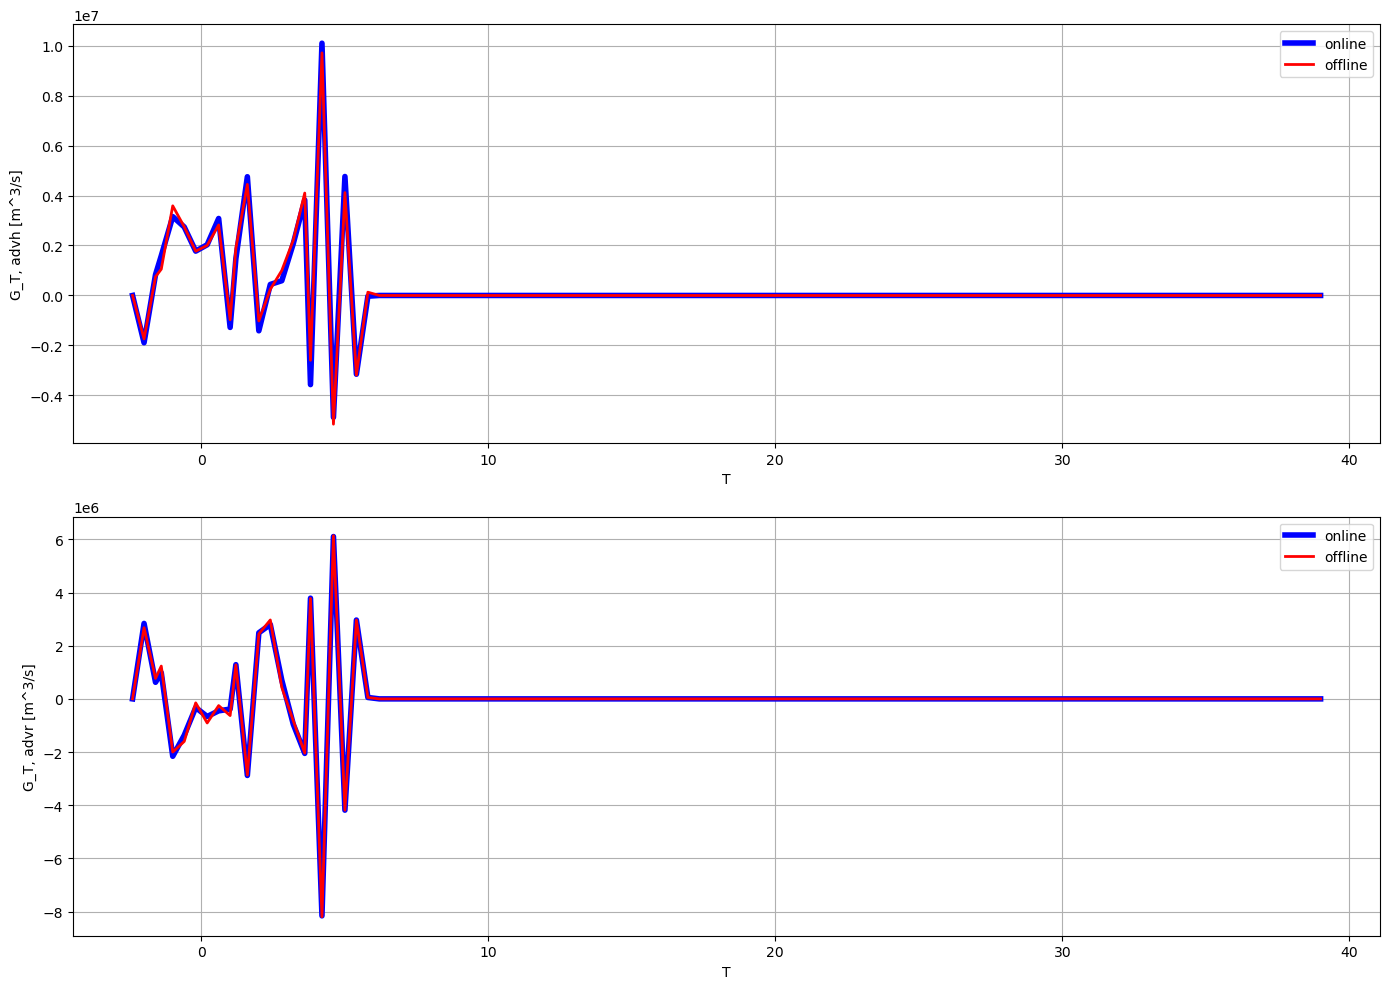

In [119]:
def _bincount_sum_with_nan(idx, values, n_bins):
    """MATLAB-like sum: if any NaN in a bin, that bin's sum is NaN."""
    idx = np.asarray(idx)
    values = np.asarray(values)
    ok = np.isfinite(values)
    s = np.bincount(idx[ok], weights=values[ok], minlength=n_bins).astype(float)
    any_nan = np.bincount(idx[~ok], minlength=n_bins) > 0
    s[any_nan] = np.nan
    return s

def plot_figure4_new(THETA, DFh, DFr, boundsT, binmidT, binwidthT1,
                     h_diff_layers, r_diff_layers, iiT=None):
    """
    Recreates Figure 4 (both panels) from replicate_layers_offline:
      Top:  G_T diffh — online vs offline(new)
      Bottom: G_T diffr — online vs offline(new)
    """
    # --- inputs & shapes ---
    THETA      = np.asarray(THETA)
    DFh        = np.asarray(DFh)
    DFr        = np.asarray(DFr)
    boundsT    = np.asarray(boundsT)
    binmidT    = np.asarray(binmidT)
    binwidthT1 = np.asarray(binwidthT1)      # length nT-1
    G_online_h = np.asarray(h_diff_layers)   # length nT-1
    G_online_r = np.asarray(r_diff_layers)   # length nT-1

    nT   = boundsT.size - 1
    nTm1 = nT - 1

    # x-locations for edge-based curves (length nTm1)
    x = boundsT[1:-1]

    # --- "new" interpretation: bin by binmidT intervals ---
    theta_flat = THETA.ravel()
    dfh_flat   = DFh.ravel()
    dfr_flat   = DFr.ravel()

    # binmidT[i] <= THETA < binmidT[i+1], i=0..nT-2
    bin_idx_mid = np.digitize(theta_flat, binmidT, right=False) - 1
    valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(theta_flat)
    idx_mid     = bin_idx_mid[valid_mid]

    # per-bin sums with NaN-propagation
    DFh_new = _bincount_sum_with_nan(idx_mid, dfh_flat[valid_mid], nTm1)
    DFr_new = _bincount_sum_with_nan(idx_mid, dfr_flat[valid_mid], nTm1)

    # edge-based G (m^3/s): divide by edge binwidths
    G_off_new_h = DFh_new / binwidthT1
    G_off_new_r = DFr_new / binwidthT1

    # selection
    if iiT is None:
        iiT = slice(None)

    # --- plot: 2 rows, 1 column ---
    plt.figure(figsize=(14, 10))
    # Top: diffh
    plt.subplot(2, 1, 1)
    plt.plot(x[iiT], G_online_h[iiT], 'b-', linewidth=4, label='online')
    plt.plot(x[iiT], G_off_new_h[iiT], 'r-', linewidth=2, label='offline')
    plt.grid(True); plt.xlabel('T'); plt.ylabel('G_T, advh [m^3/s]')
    plt.legend(); plt.axis('tight')

    # Bottom: diffr
    plt.subplot(2, 1, 2)
    plt.plot(x[iiT], G_online_r[iiT], 'b-', linewidth=4, label='online')
    plt.plot(x[iiT], G_off_new_r[iiT], 'r-', linewidth=2, label='offline')
    plt.grid(True); plt.xlabel('T'); plt.ylabel('G_T, advr [m^3/s]')
    plt.legend(); plt.axis('tight')

    plt.tight_layout()

# Example:
a = ADVh*mymsk3d
a[np.isnan(a)] = 0
b = ADVr*mymsk3d
b[np.isnan(b)] = 0
plot_figure4_new(THETA, a, b, boundsT.flatten(), binmidT.flatten(), binwidthT1,
                               GADVh, GADVr, iiT=None)
plt.show()


In [121]:
import numpy as np

def compute_G_T_offline_new(
    THETA, DFh, DFr, ADVh, ADVr,
    boundsT, binmidT, binwidthT1,
    region_mask_2d
):
    """
    Python analogue of the MATLAB block:

      G_T_offline_new=zeros(6,nTm1);
      dF_Tnew=zeros(6,nTm1);
      Lijnew=zeros(6,nTm1);

      tmp=T(ind,:);
      for i=1:nTm1
        ij=find(tmp(:)>=binmidT(i) & tmp(:)<binmidT(i+1));
        Lijnew(i)=length(ij);
        if(Lijnew(i)>0);
          tmpp=reshape(ff.DFh,nx*ny,nz);tmpp=tmpp(ind,:);
          dF_Tnew(2,i)=sum(tmpp(ij));
          tmpp=reshape(ff.DFr,nx*ny,nz);tmpp=tmpp(ind,:);
          dF_Tnew(3,i)=sum(tmpp(ij));
          tmpp=reshape(ff.advh,nx*ny,nz);tmpp=tmpp(ind,:);
          dF_Tnew(4,i)=sum(tmpp(ij));
          tmpp=reshape(ff.advr,nx*ny,nz);tmpp=tmpp(ind,:);
          dF_Tnew(5,i)=sum(tmpp(ij));
        end
      end
      G_T_offline_new = dF_Tnew ./ repmat(binwidthT1,[6 1]);

    All reshapes are done in Fortran order ('F') to match MATLAB.
    """

    # --- convert to arrays ---
    THETA      = np.asarray(THETA)
    DFh        = np.asarray(DFh)
    DFr        = np.asarray(DFr)
    ADVh       = np.asarray(ADVh)
    ADVr       = np.asarray(ADVr)
    boundsT    = np.asarray(boundsT)
    binmidT    = np.asarray(binmidT)
    binwidthT1 = np.asarray(binwidthT1)
    region_mask_2d = np.asarray(region_mask_2d)

    nx, ny, nz = THETA.shape
    nT   = boundsT.size - 1
    nTm1 = nT - 1

    if binmidT.size != nT:
        raise ValueError("binmidT must have length nT = boundsT.size - 1")
    if binwidthT1.size != nTm1:
        raise ValueError("binwidthT1 must have length nT-1")

    # --- region indices (equivalent to 'ind' in MATLAB) ---
    # MATLAB's reshape is column-major; use order='F' to match.
    if region_mask_2d.shape != (ny, nx):
        raise ValueError("region_mask_2d must have shape (nx, ny)")

    mask_flat = region_mask_2d.ravel(order="F") != 0   # logical region mask (nx*ny,)
    ind = np.where(mask_flat)[0]                       # 1D indices, same as MATLAB 'ind'

    # --- reshape to (nx*ny, nz) in Fortran order, then restrict to region ---
    T_2d    = np.reshape(THETA, (nz, nx * ny), order="F")
    DFh_2d  = np.reshape(DFh,   (nz, nx * ny), order="F")
    DFr_2d  = np.reshape(DFr,   (nz, nx * ny), order="F")
    ADVh_2d = np.reshape(ADVh,  (nz, nx * ny), order="F")
    ADVr_2d = np.reshape(ADVr,  (nz, nx * ny), order="F")

    # Restrict to region (Lreg x nz)
    T_reg    = T_2d[:,ind]
    DFh_reg  = DFh_2d[:,ind]
    DFr_reg  = DFr_2d[:,ind]
    ADVh_reg = ADVh_2d[:,ind]
    ADVr_reg = ADVr_2d[:,ind]

    # Flatten in Fortran order to mimic tmp(:) and tmpp(:) in MATLAB
    T_flat    = T_reg.ravel(order="F")
    DFh_flat  = DFh_reg.ravel(order="F")
    DFr_flat  = DFr_reg.ravel(order="F")
    ADVh_flat = ADVh_reg.ravel(order="F")
    ADVr_flat = ADVr_reg.ravel(order="F")

    # --- allocate outputs (6 x nTm1) ---
    # Index mapping (Python 0-based) to match MATLAB rows:
    #   1 -> diffh  -> idx 1
    #   2 -> diffr  -> idx 2
    #   3 -> advh   -> idx 3
    #   4 -> advr   -> idx 4
    # rows 0 and 5 (surf, tot) stay zero unless you want to fill them.
    G_T_offline_new = np.zeros((6, nTm1), dtype=float)
    dF_Tnew         = np.zeros((6, nTm1), dtype=float)
    Lijnew          = np.zeros(nTm1, dtype=int)

    # --- main binning loop over T-edges (binmidT intervals) ---
    for i in range(nTm1):
        lo = binmidT[i]
        hi = binmidT[i + 1]

        # Equivalent to: ij = find(tmp(:)>=binmidT(i) & tmp(:)<binmidT(i+1));
        in_bin = (T_flat >= lo) & (T_flat < hi)
        ij = np.where(in_bin)[0]
        Lijnew[i] = ij.size

        if Lijnew[i] > 0:
            # degC m^3/s at T_center for each process
            dF_Tnew[1, i] = np.sum(DFh_flat[ij])   # diffh
            dF_Tnew[2, i] = np.sum(DFr_flat[ij])   # diffr
            dF_Tnew[3, i] = np.sum(ADVh_flat[ij])  # advh
            dF_Tnew[4, i] = np.sum(ADVr_flat[ij])  # advr

    # Divide by binwidthT1 along T dimension => m^3/s at T-edges
    G_T_offline_new = dF_Tnew / binwidthT1[np.newaxis, :]

    return G_T_offline_new, dF_Tnew, Lijnew


# THETA, DFh, DFr, ADVh, ADVr: shape (nx, ny, nz), already masked with hf (NaNs on land/obcs)
# region_mask_2d: e.g. (mskBasin == 200) * hf[:,:,0] > 0, shape (nx, ny)

G_T_off_new, dF_Tnew, Lijnew = compute_G_T_offline_new(
    THETA=THETA,
    DFh=DFh,       # horizontal diffusion convergence
    DFr=DFr,       # vertical diffusion convergence
    ADVh=ADVh,     # horizontal advective convergence
    ADVr=ADVr,     # vertical advective convergence
    boundsT=boundsT,
    binmidT=binmidT,
    binwidthT1=binwidthT1,
    region_mask_2d=mymsk,
)

# X-locations (T edges, length nTm1) to compare with online layers:
x = boundsT[1:-1]

# Compare to online G_T (diffh / diffr)
plt.figure()
plt.subplot(2,1,1)
plt.plot(x, GADVh,           "b-", linewidth=4, label="online diffh")
plt.plot(x, G_T_off_new[1,:],"r-", linewidth=2, label="offline diffh")
plt.grid(True); plt.legend(); plt.xlabel("T"); plt.ylabel("G_T (m^3/s)")

plt.subplot(2,1,2)
plt.plot(x, GADVr,           "b-", linewidth=4, label="online diffr")
plt.plot(x, G_T_off_new[2,:],"r-", linewidth=2, label="offline diffr")
plt.grid(True); plt.legend(); plt.xlabel("T"); plt.ylabel("G_T (m^3/s)")
plt.tight_layout()


ValueError: region_mask_2d must have shape (nx, ny)

### do the same with the diffusive convergence

In [108]:

## do the advective convergence
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["DFxE_TH","DFyE_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFxE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFyE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])


# now 3d zfluxes
file_name = "budg3d_zflux_set1"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFrE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFrI_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)

In [109]:
DF_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(DFxE_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(DFyE_TH.reshape(nz, ny, nx), nfx, nfy))
DF_hconv = DF_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
DFh = DF_hconv

trWtopDF = -(DFrE_TH+DFrI_TH)

DFr = np.zeros((nz,ny,nx),dtype=float)
DFr[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])

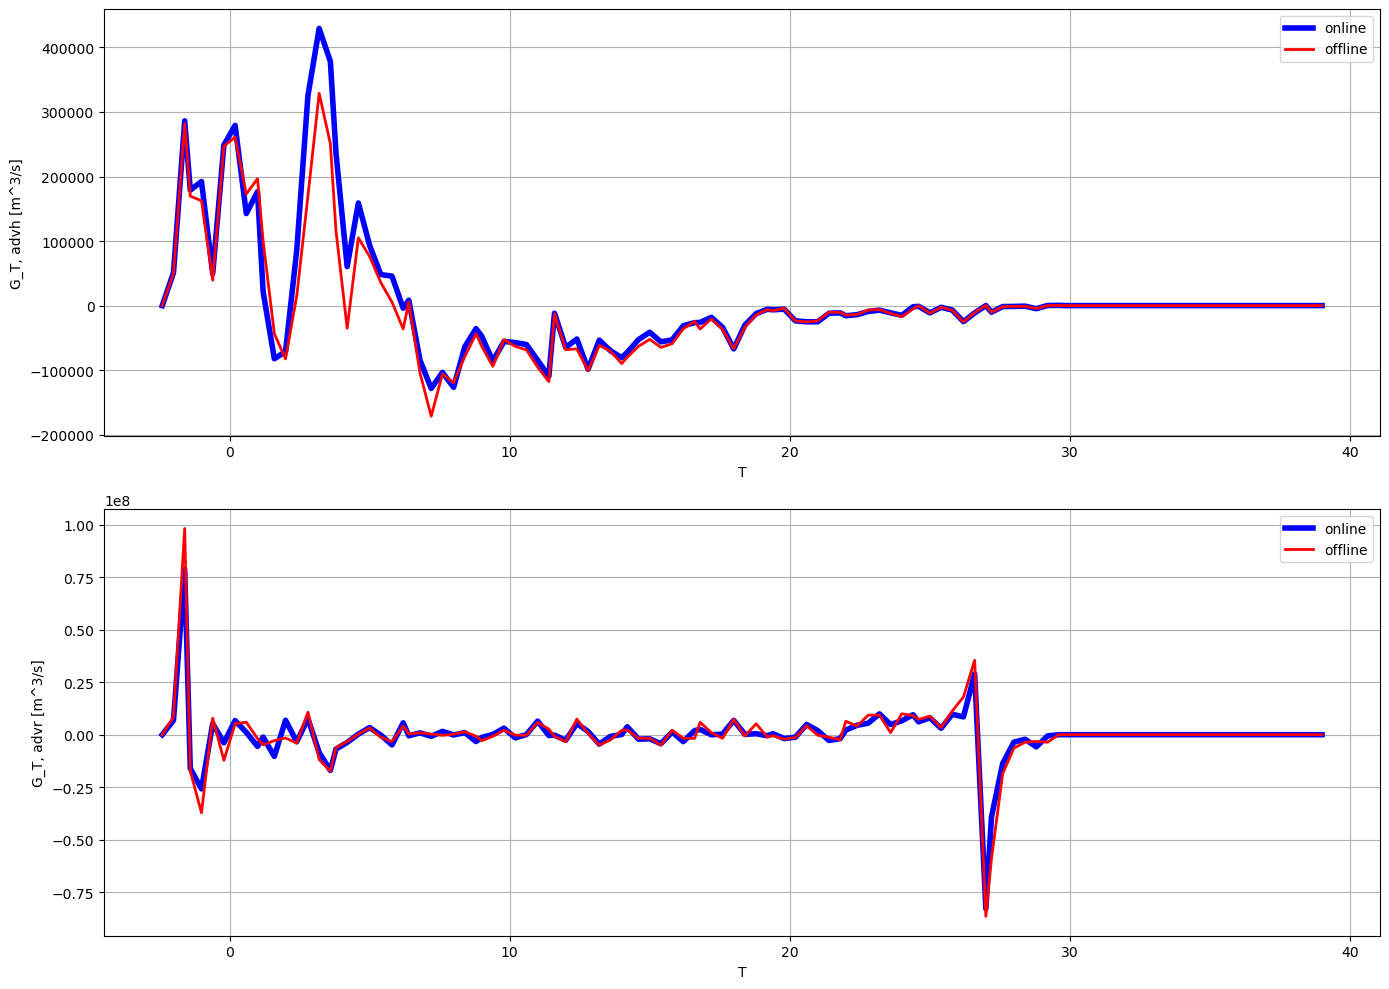

In [111]:
# Example:
a = DFh#*mymsk3d
a[np.isnan(a)] = 0
b = DFr#*mymsk3d
b[np.isnan(b)] = 0
plot_figure4_new(THETA, a, b, boundsT.flatten(), binmidT.flatten(), binwidthT1,
                               GDFh, GDFr, iiT=None)
plt.show()

### do the same now with the surface term

In [85]:
# to get the surface term, we need J/s and convert to degC.m^3/s
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[2])
TFLUX = TFLUX.reshape(ny,nx)
oceQsw = oceQsw.reshape(ny,nx)
SItflux = SItflux.reshape(ny,nx)

In [86]:
# we need to create zconv_top and swtop
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0
swtop=mk3D_mod(swfrac,np.zeros((nz,ny,nx)))*mk3D_mod(RAC*oceQsw,np.zeros((nz,ny,nx)))   # J/s

# zconvtop_heat is here
zconv_top_heat = TFLUX * RAC     # W/m^2 * m^2 = J/s

In [87]:

def surface_contrib_JT(zconv_top_heat, swtop, rcp, fill_last=0.0):
    """
    zconv_top_heat: (ny, nx)
    swtop:          (nz, ny, nx)
    rcp:            scalar
    fill_last:      value for bottom slice (k = nz-1), usually 0.0 or np.nan
    returns:
      JsurfT:       (nz, ny, nx)  # Sv / PSU
    """
    nz, ny, nx = swtop.shape

    eT = zconv_top_heat.reshape(1, ny, nx)  # (1,ny,nx) for broadcast

    J = np.empty_like(swtop, dtype=float)

    # k = 0: (eT - fT[1]) / rcp / dT / dS * 1e-6
    J[0] = (eT[0] - swtop[1]) / rcp if np.ndim(binwidthT)==0 else \
           (eT[0] - swtop[1]) / rcp

    # 1 .. nz-2: -(fT[k+1]-fT[k]) / rcp / dT / dS * 1e-6
    J[1:nz-1] = -(swtop[2:nz] - swtop[1:nz-1]) / rcp

    # bottom slice (k = nz-1): no k+1; choose your boundary convention
    J[-1] = fill_last
    return J

Ft_surftest = surface_contrib_JT(zconv_top_heat,swtop,myparms['rcp'])    # this is in degC.m^3/s

In [88]:

def plot_figure4_1(THETA, DFh, DFr, boundsT, binmidT, binwidthT1,
                     h_diff_layers, r_diff_layers, iiT=None):
    """
    Recreates Figure 4 (both panels) from replicate_layers_offline:
      Top:  G_T diffh — online vs offline(new)
      Bottom: G_T diffr — online vs offline(new)
    """
    # --- inputs & shapes ---
    THETA      = np.asarray(THETA)
    DFh        = np.asarray(DFh)
    DFr        = np.asarray(DFr)
    boundsT    = np.asarray(boundsT)
    binmidT    = np.asarray(binmidT)
    binwidthT1 = np.asarray(binwidthT1)      # length nT-1
    G_online_h = np.asarray(h_diff_layers)   # length nT-1
    G_online_r = np.asarray(r_diff_layers)   # length nT-1

    nT   = boundsT.size - 1
    nTm1 = nT - 1

    # x-locations for edge-based curves (length nTm1)
    x = boundsT[1:-1]

    # --- "new" interpretation: bin by binmidT intervals ---
    theta_flat = THETA.ravel()
    dfh_flat   = DFh.ravel()
    dfr_flat   = DFr.ravel()

    # binmidT[i] <= THETA < binmidT[i+1], i=0..nT-2
    bin_idx_mid = np.digitize(theta_flat, binmidT, right=False) - 1
    valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(theta_flat)
    idx_mid     = bin_idx_mid[valid_mid]

    # per-bin sums with NaN-propagation
    DFh_new = _bincount_sum_with_nan(idx_mid, dfh_flat[valid_mid], nTm1)
    DFr_new = _bincount_sum_with_nan(idx_mid, dfr_flat[valid_mid], nTm1)

    # edge-based G (m^3/s): divide by edge binwidths
    G_off_new_h = DFh_new / binwidthT1
    G_off_new_r = DFr_new / binwidthT1

    # selection
    if iiT is None:
        iiT = slice(None)

    # --- plot: 2 rows, 1 column ---
    plt.figure(figsize=(14, 5))
    # Top: diffh
    plt.subplot(1, 1, 1)
    plt.plot(x[iiT], G_online_h[iiT], 'b-', linewidth=4, label='online')
    plt.plot(x[iiT], G_off_new_h[iiT], 'r-', linewidth=2, label='offline')
    plt.grid(True); plt.xlabel('T'); plt.ylabel('G_T, surface [m^3/s]')
    plt.legend(); plt.axis('tight')

    plt.tight_layout()

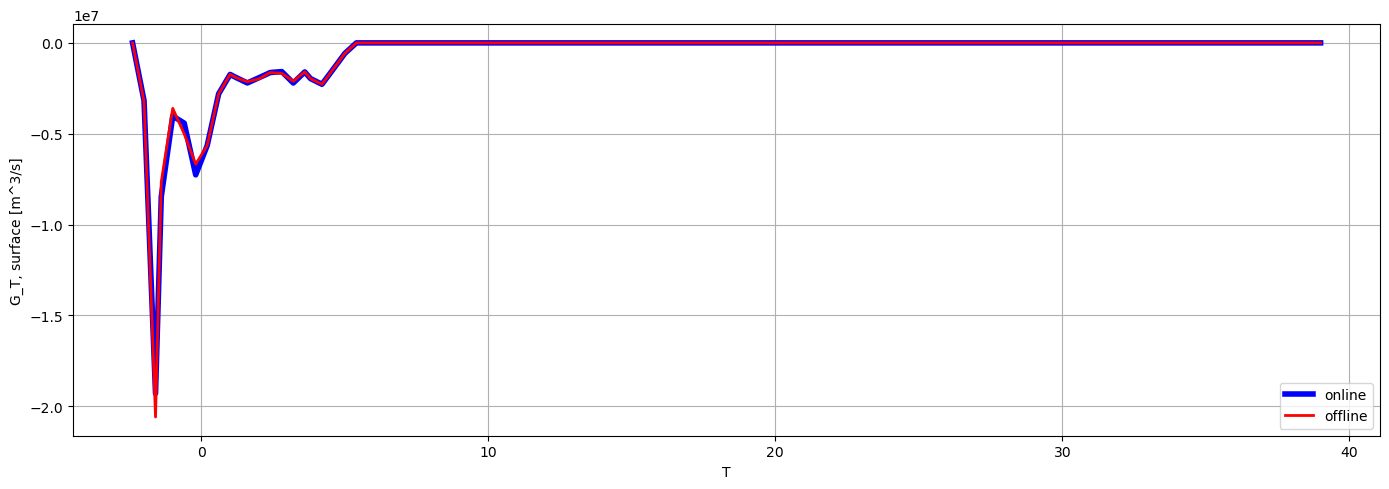

In [89]:
# we still need to multiply Ft_surftest by the mask but ideally if we follow the same algo this will be
# the same as the G term from the layers

a = Ft_surftest*mymsk3d
a[np.isnan(a)] = 0

plot_figure4_1(THETA, a, b, boundsT.flatten(), binmidT.flatten(), binwidthT1,
                               Gsurf, GDFr, iiT=None)
plt.show()

### we need to also sort out KPP and the total tend

In [90]:
# # first plot the overall G terms and the residual

# Gsurf
# GDFh
# GDFr
# GADVh
# GADVr
# Gtottend

(-4.470000100135803,
 41.070000004768374,
 -28935538.213650998,
 37931299.42694723)

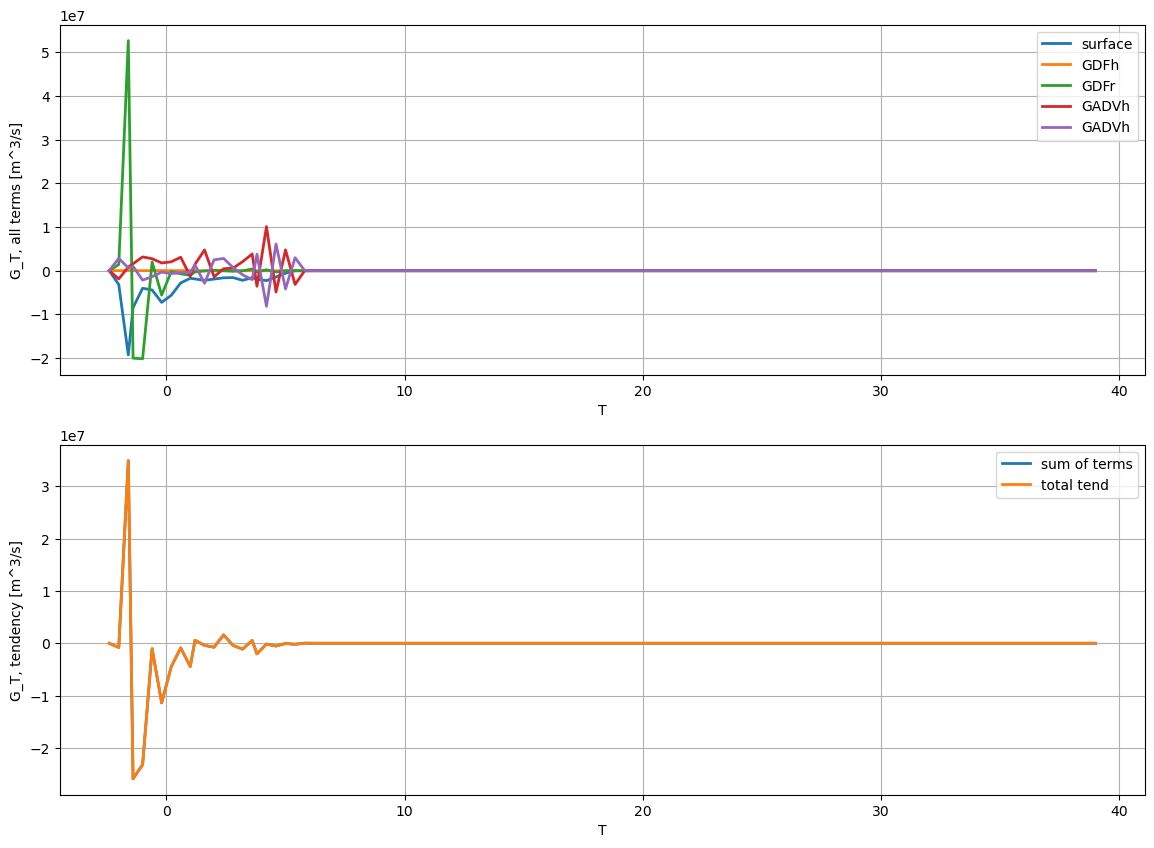

In [91]:
# just plot these first and sum them as a first order task

fig = plt.figure(figsize = (14,10))

ax = plt.subplot(211)
ax.plot(boundsT.flatten()[1:-1], Gsurf, linewidth=2, label='surface')
ax.plot(boundsT.flatten()[1:-1], GDFh, linewidth=2, label='GDFh')
ax.plot(boundsT.flatten()[1:-1], GDFr, linewidth=2, label='GDFr')
ax.plot(boundsT.flatten()[1:-1], GADVh, linewidth=2, label='GADVh')
ax.plot(boundsT.flatten()[1:-1], GADVr, linewidth=2, label='GADVh')
ax.grid(True); ax.set_xlabel('T'); ax.set_ylabel('G_T, all terms [m^3/s]')
ax.legend(); ax.axis('tight')

ax = plt.subplot(212)
ax.plot(boundsT.flatten()[1:-1], Gsurf + GDFh + GDFr + GADVh + GADVr, linewidth=2, label='sum of terms')
ax.plot(boundsT.flatten()[1:-1], Gtottend, linewidth=2, label='total tend')
ax.grid(True); ax.set_xlabel('T'); ax.set_ylabel('G_T, tendency [m^3/s]')
ax.legend(); ax.axis('tight')

In [92]:
dt = ts2dte(int(tsstr[1]), deltat=1200, startyr=1992, startmo=1, startdy=1)-ts2dte(int(tsstr[0]), deltat=1200, startyr=1992, startmo=1, startdy=1)   # days
print(dt)
dt = dt.total_seconds()
dt

0:20:00


1200.0

In [93]:
# we should also get the total tendency from the theta timeseries from ASTE 90
# we want the total tendency of volume(!) in m^3/s from the theta (J/s)

# load the tend from the get_Jterms and plot this

file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisTHETADR,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisTHETADR = thisTHETADR.reshape(nz,ny,nx)
    THETADR[i] = thisTHETADR

THETADR =  (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt*.7    # degC.m/
AB_gT = 0
tmptend=(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)   # degC.m/s * m^2 = degC.m^3/s
tmptend = tmptend                          # degC.m^3/s

In [94]:
# bin this tmptend using THETA and mask it
# binned_theta
# myparms['rcp']

# SOMETHING IS WRONG HERE. WE NEED TO SORT THIS OUT AT HOME. BUT CONTINUE WITH KPP

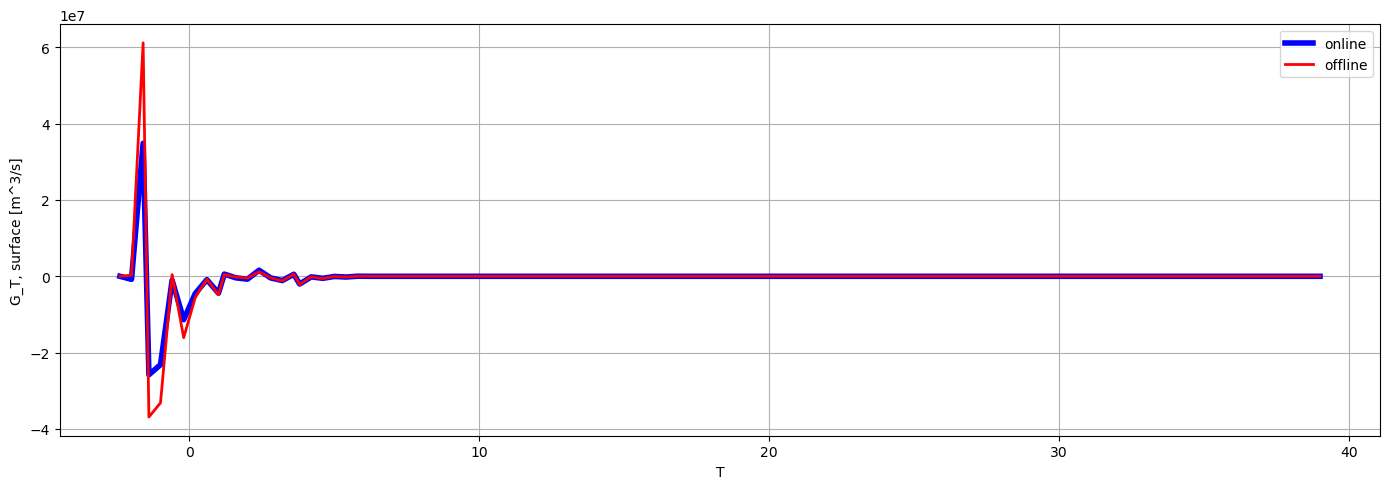

In [95]:
# now we should be able to plot the same tmptend with the total tend from layers
a = tmptend*mymsk3d
a[np.isnan(a)] = 0

plot_figure4_1(THETA, a, b, boundsT.flatten(), binmidT.flatten(), binwidthT1,
                               Gtottend, GDFr, iiT=None)
plt.show()

In [96]:
# sort out the KPP total tend in T space and see how this compares with DF, then we go home

In [97]:
# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["KPPg_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
KPPg_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_TH = KPPg_TH.reshape(nz,ny,nx)

# do the vertical convergence for KPP
trWtopKPP = -(KPPg_TH)         # degC.m^3/s

tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]

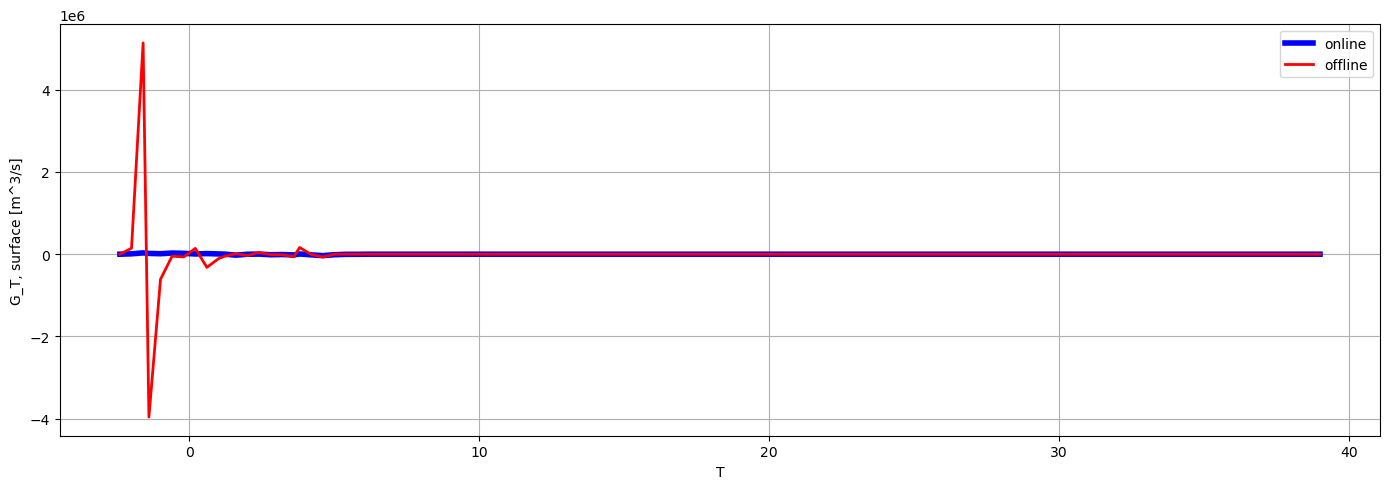

In [98]:
a = tmpkpp*mymsk3d
a[np.isnan(a)] = 0

plot_figure4_1(THETA, a, b, boundsT.flatten(), binmidT.flatten(), binwidthT1,
                               GDFh, GDFr, iiT=None)
plt.show()

In [99]:
# # let's look at the sum of the terms from the tmpkpp, hadv, vadv, hdiff, vdiff, and surface
# a = tmpkpp*mymsk3d
# a[np.isnan(a)] = 0

# b = tmptend*mymsk3d
# b[np.isnan(b)] = 0

# a = Ft_surftest*mymsk3d
# a[np.isnan(a)] = 0

# a = DFh*mymsk3d
# a[np.isnan(a)] = 0
# b = DFr*mymsk3d
# b[np.isnan(b)] = 0

# a = ADVh*mymsk3d
# a[np.isnan(a)] = 0
# b = ADVr*mymsk3d
# b[np.isnan(b)] = 0

In [100]:
def _bincount_sum_with_nan(idx, vals, nout):
    """
    NaN-aware per-bin sum:
    if *all* entries in a bin are NaN, that bin returns NaN;
    otherwise NaNs are ignored and finite values are summed.
    """
    # track counts of non-nan contributions
    finite = np.isfinite(vals)
    sums   = np.bincount(idx[finite], vals[finite], minlength=nout).astype(float)
    counts = np.bincount(idx[finite], None, minlength=nout).astype(float)
    out = sums
    out[counts == 0] = np.nan
    return out

def plot_figure4_components(
    THETA,
    boundsT,
    binmidT,
    binwidthT1,
    *,
    iiT=None,
    mask=None,
    tendency_name="tmptend",
    **terms
):
    """
    Bin arbitrary component terms by temperature using binmidT intervals and plot:
      Top panel:   each term vs. T (edge-based, divided by binwidthT1)
      Bottom panel: sum(all components except 'tendency_name') vs the tendency term

    Parameters
    ----------
    THETA : array-like
        Tracer field used for binning. Shape must match each term.
    boundsT : 1D array-like
        Bin *edges* (length nT+1). x-locations will be boundsT[1:-1] (length nT-1).
    binmidT : 1D array-like
        Mid-bin edges used to define intervals: binmidT[i] <= THETA < binmidT[i+1]
        Length nT.
    binwidthT1 : 1D array-like
        Edge bin widths (length nT-1), used to convert summed fluxes to edge-based G.
    iiT : slice or 1D index array, optional
        Selection along the temperature-edge axis (length nT-1). Defaults to all.
    mask : array-like, optional
        Same shape as THETA (and each term). Elements where mask is falsy are ignored.
        If provided, terms are multiplied by mask and NaNs are set to zero for counting.
    tendency_name : str, default 'tmptend'
        The key in **terms that should be treated as the tendency curve on panel 2.
    **terms : dict of name -> array-like
        Component arrays to include (e.g., tmpkpp=..., ADVh=..., vdiff=..., surface=..., etc.)
        All arrays must have the same shape as THETA.

    Notes
    -----
    - The binning follows the “new” interpretation used previously:
        binmidT[i] <= THETA < binmidT[i+1], for i = 0..(nT-2)
      which yields nT-1 edge bins.
    - Each component is summed per bin, then divided by `binwidthT1` to give an
      edge-based G-like quantity per temperature edge.
    """

    # --- validate & prepare shapes ---
    THETA      = np.asarray(THETA)
    boundsT    = np.asarray(boundsT)
    binmidT    = np.asarray(binmidT)
    binwidthT1 = np.asarray(binwidthT1)

    if mask is not None:
        mask = np.asarray(mask)
        if mask.shape != THETA.shape:
            raise ValueError("mask must have the same shape as THETA")

    nT   = boundsT.size - 1
    nTm1 = nT - 1
    if binmidT.size != nT:
        raise ValueError("binmidT must have length nT (= len(boundsT)-1)")
    if binwidthT1.size != nTm1:
        raise ValueError("binwidthT1 must have length nT-1 (= len(boundsT)-2 + 1)")

    # x-locations for edge-based curves (length nT-1)
    x = boundsT[1:-1]

    # default selection
    if iiT is None:
        iiT = slice(None)

    # --- flatten for binning ---
    theta_flat = THETA.ravel()

    # build the bin index via binmidT intervals
    # binmidT[i] <= THETA < binmidT[i+1], i = 0..nT-2
    bin_idx_mid = np.digitize(theta_flat, binmidT, right=False) - 1
    valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(theta_flat)

    # if mask provided, fold it into validity
    if mask is not None:
        valid_mid &= (mask.ravel().astype(bool))

    idx_mid = bin_idx_mid[valid_mid]

    # --- per-term binning and edge conversion ---
    G_terms = {}  # name -> (nT-1,) array
    for name, arr in terms.items():
        arr = np.asarray(arr)
        if arr.shape != THETA.shape:
            raise ValueError(f"term '{name}' must have the same shape as THETA")

        vals = arr.ravel().astype(float)

        # Apply mask behavior similar to your snippets:
        #   multiply by mask, set NaNs to 0 for accumulation, but preserve 'all-NaN' as NaN via helper.
        if mask is not None:
            vals = vals * mask.ravel()

        # NaN-aware bin sums (helper will return NaN for bins with no finite contributions)
        S = _bincount_sum_with_nan(idx_mid, vals[valid_mid], nTm1)

        # Convert to edge-based G by dividing by binwidthT1
        G_terms[name] = S / binwidthT1

    # Separate tendency from components-to-sum
    tend_curve = G_terms.get(tendency_name, None)
    comp_names = [k for k in G_terms.keys() if k != tendency_name]

    # Sum across components (excluding tendency)
    if comp_names:
        G_sum = np.nansum(np.vstack([G_terms[k] for k in comp_names]), axis=0)
    else:
        G_sum = np.full(nTm1, np.nan)

    # --- plot ---
    plt.figure(figsize=(14, 8))

    # Top: every component vs T
    ax1 = plt.subplot(2, 1, 1)
    for name in comp_names:
        ax1.plot(x[iiT], G_terms[name][iiT], linewidth=2, label=name)
    if not comp_names:
        ax1.plot([], [], label="(no components provided)")
    ax1.grid(True)
    ax1.set_xlabel('T')
    ax1.set_ylabel('G_T [m^3/s]')
    ax1.set_title('Components by T (edge-based)')
    ax1.legend(ncol=2)
    ax1.axis('tight')

    # Bottom: sum(components) vs tendency
    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(x[iiT], G_sum[iiT], linewidth=3, label='sum(components)')
    if tend_curve is not None:
        ax2.plot(x[iiT], tend_curve[iiT], linewidth=2, linestyle='--', label=tendency_name)
    else:
        # If no tendency provided, still show just the sum
        ax2.plot([], [], label=f"(no '{tendency_name}' provided)")
    ax2.grid(True)
    ax2.set_xlabel('T')
    ax2.set_ylabel('G_T [m^3/s]')
    ax2.set_title('Sum of components vs. tendency')
    ax2.legend()
    ax2.axis('tight')

    plt.tight_layout()


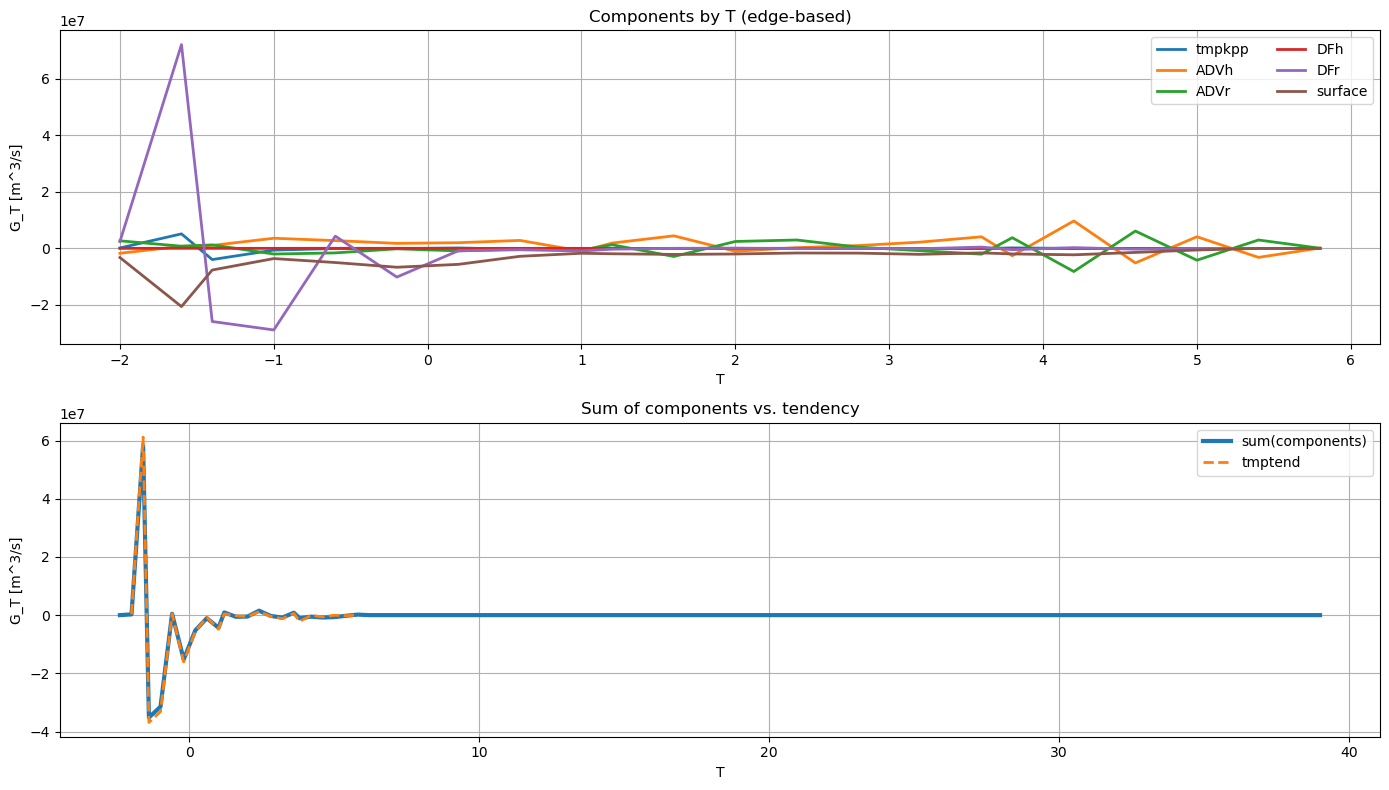

In [101]:
plot_figure4_components(
    THETA,
    boundsT.flatten(),
    binmidT.flatten(),
    binwidthT1.flatten(),
    mask=mymsk3d,                 # optional
    tendency_name="tmptend",      # change if your tendency is named differently
    tmpkpp=tmpkpp,
    ADVh=ADVh,
    ADVr=ADVr,
    DFh=DFh,
    DFr=DFr,
    surface=Ft_surftest,
    tmptend=tmptend,              # this will be the dashed curve on panel 2
)


## We still need to work on getting 1) the gateway term to be the same as the ADV term and 2) another look at the tendency (fishy)

## try to do the same with the Salinity budget here, then do the gates

In [74]:
# we will just do the exact same thing for all the terms

ffac=1e-6
G_T=np.array([])
metaS=parsemeta(layers_path + "diags/LAYERS/layers_3d_Stend." + "0000000003" + ".meta")
nFldsS = metaS["fldList"]
print(len(nFldsT))
setTtend=nFldsT.copy()


# check for the correct diagnostics
metaS['fldList']   # 13, 14, 15, 16, 19, 22
b = metaS['fldList']
# ['LaSs1SLT' 'LaSh1SLT' 'LaSz1SLT' 'LSha1SLT' 'LSza1SLT' 'LSto1SLT']
ifldS = np.array([12,13,14,19,20,23])

# print(b[12,13,14,19,20,23])
print(np.array(b)[ifldS])  # for G_S

24
['LaSs1SLT' 'LaSh1SLT' 'LaSz1SLT' 'LSha1SLT' 'LSza1SLT' 'LSto1SLT']


In [77]:
# make sure we have the correct mask based on mymsk

# load the G_T terms again with the mask in mind
# this will be a width 1 list
mymsk_1dtile = np.tile(mymsk_1d[np.newaxis,:],(nT-1,1))


# make the G_T term
G_S = {}
G_S["BarentsS"] = {}
    
# now loop through
G_S["BarentsS"][ts] = {}
for i in range(len(ifldS)-1, -1, -1):
    tmp = read_float64_skip(layers_path + "diags/LAYERS/layers_3d_Stend." + tsstr[-1] + ".data", nx*ny*(nS-1),ifldS[i])
    tmp = np.reshape(tmp,(nS-1,nx*ny))

    # here we will want to multiply by the mask for the Barents Sea
    tmp = tmp * mymsk_1dtile * (rac2dtile * hf2dtile) #* ffac

    if i == ifldS.shape[0]-1:
        # if LTto2TH, do not remove from residual
        residS = tmp
    else:
        # else if vADV, hADV, vDiff, hDiff, surface, remove from residual
        residS = residT-tmp
    
    # just do the Barents Sea for this one
    a = np.nansum(tmp,axis=1)
    G_S["BarentsS"][ts][setTtend[ifldS[i]]] = a

G_S["BarentsS"][ts]["residS"] = np.nansum(residS,axis=1)

In [79]:
# check the convergence of the layers (we read correctly)

name = "BarentsS"
Gsurf = G_S[name][ts]['LaSs1SLT']
GDFh  = G_S[name][ts]['LaSh1SLT']
GDFr  = G_S[name][ts]['LaSz1SLT']
GADVh = G_S[name][ts]['LSha1SLT']
GADVr = G_S[name][ts]['LSza1SLT']
Gtottend = G_S[name][ts]['LSto1SLT']

(-4.470000100135803, 41.070000004768374, -41781033.27408337, 43110024.44593838)

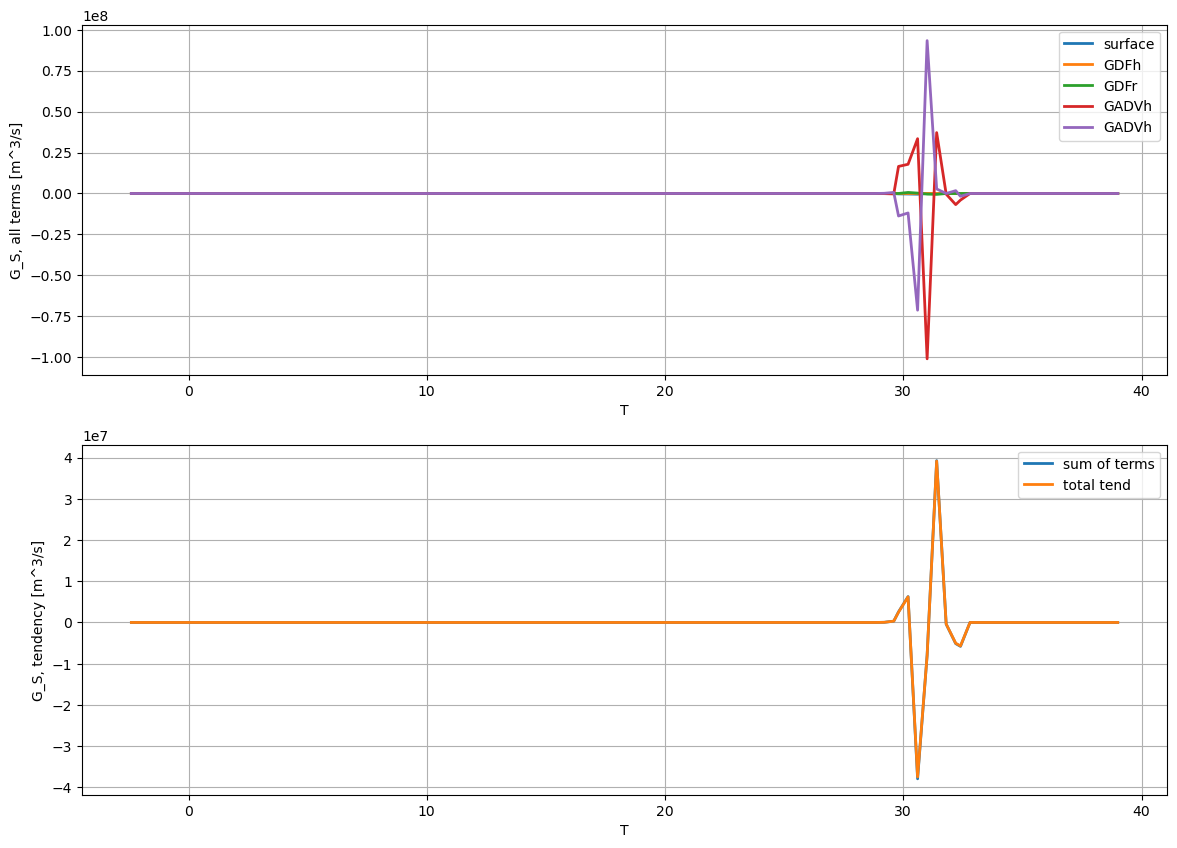

In [80]:
# just plot these first and sum them as a first order task

fig = plt.figure(figsize = (14,10))

ax = plt.subplot(211)
ax.plot(boundsT.flatten()[1:-1], Gsurf, linewidth=2, label='surface')
ax.plot(boundsT.flatten()[1:-1], GDFh, linewidth=2, label='GDFh')
ax.plot(boundsT.flatten()[1:-1], GDFr, linewidth=2, label='GDFr')
ax.plot(boundsT.flatten()[1:-1], GADVh, linewidth=2, label='GADVh')
ax.plot(boundsT.flatten()[1:-1], GADVr, linewidth=2, label='GADVh')
ax.grid(True); ax.set_xlabel('T'); ax.set_ylabel('G_S, all terms [m^3/s]')
ax.legend(); ax.axis('tight')

ax = plt.subplot(212)
ax.plot(boundsT.flatten()[1:-1], Gsurf + GDFh + GDFr + GADVh + GADVr, linewidth=2, label='sum of terms')
ax.plot(boundsT.flatten()[1:-1], Gtottend, linewidth=2, label='total tend')
ax.grid(True); ax.set_xlabel('T'); ax.set_ylabel('G_S, tendency [m^3/s]')
ax.legend(); ax.axis('tight')

In [81]:
# cool, layers is loaded correctly. check the other terms

In [84]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)

hf = mygrid['hFacC']

ADV_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_SLT.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_SLT.reshape(nz, ny, nx), nfx, nfy))
ADV_hconv = ADV_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVh = ADV_hconv

trWtopADV = -(ADVr_SLT)

ADVr = np.zeros((nz,ny,nx),dtype=float)
ADVr[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])  # this is not the way we did it in the original code but this is the way An has done it so we try

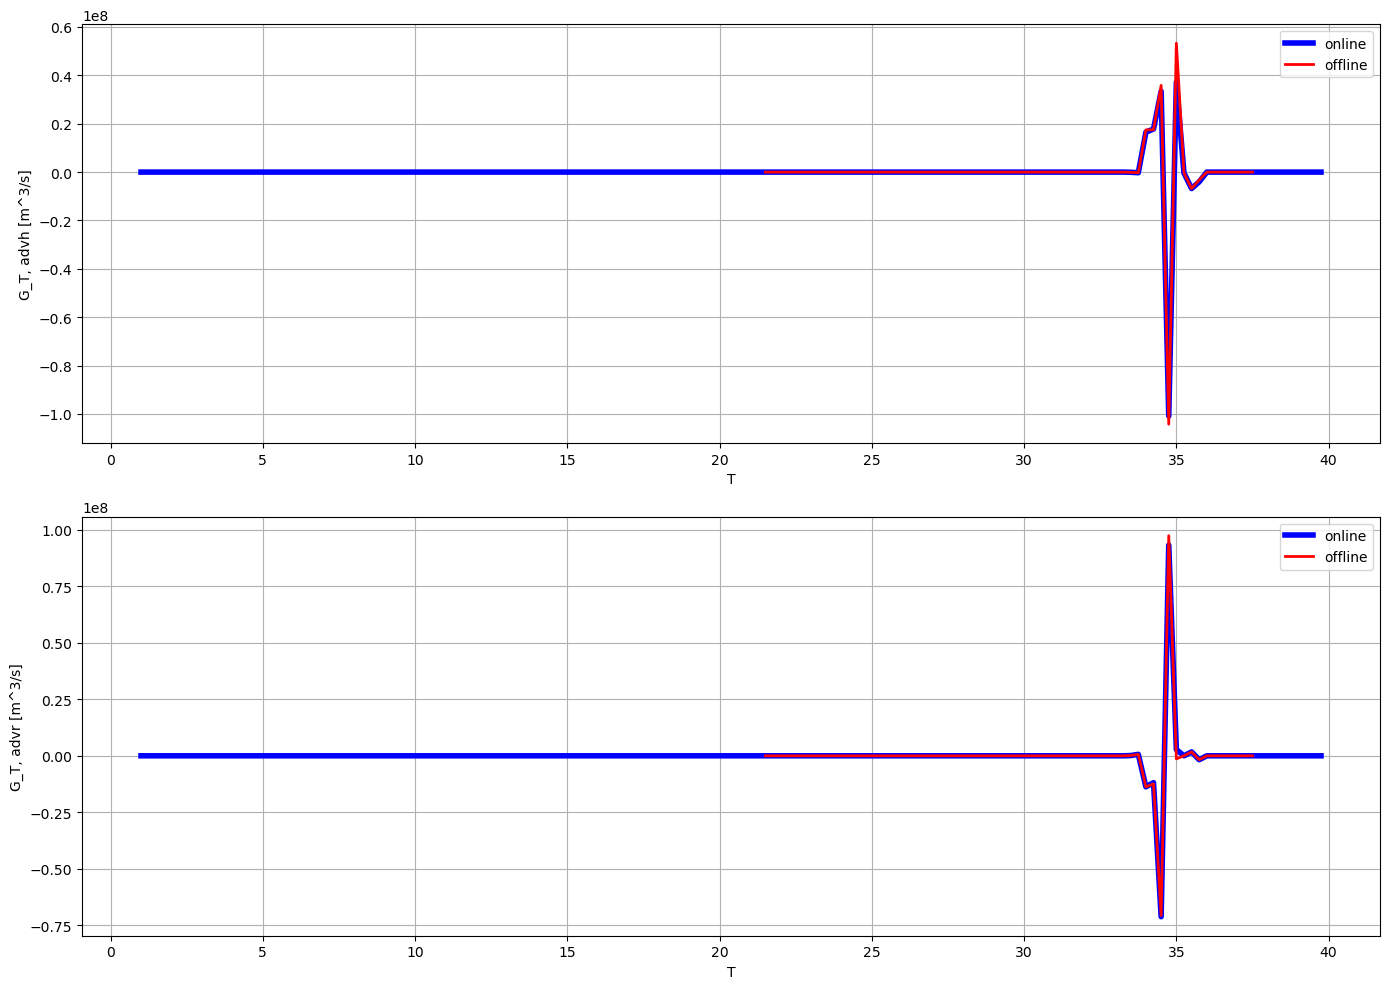

In [85]:
a = ADVh*mymsk3d
a[np.isnan(a)] = 0
b = ADVr*mymsk3d
b[np.isnan(b)] = 0
plot_figure4_new(SALT, a, b, boundsS.flatten(), binmidS.flatten(), binwidthS1,
                               GADVh, GADVr, iiT=None)
plt.show()

In [87]:
# cool, do the same for diff


## do the advective convergence
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFxE_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFyE_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFrI_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

In [88]:
DF_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(DFxE_SLT.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(DFyE_SLT.reshape(nz, ny, nx), nfx, nfy))
DF_hconv = DF_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
DFh = DF_hconv

trWtopDF = -(DFrE_SLT+DFrI_SLT)

DFr = np.zeros((nz,ny,nx),dtype=float)
DFr[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])

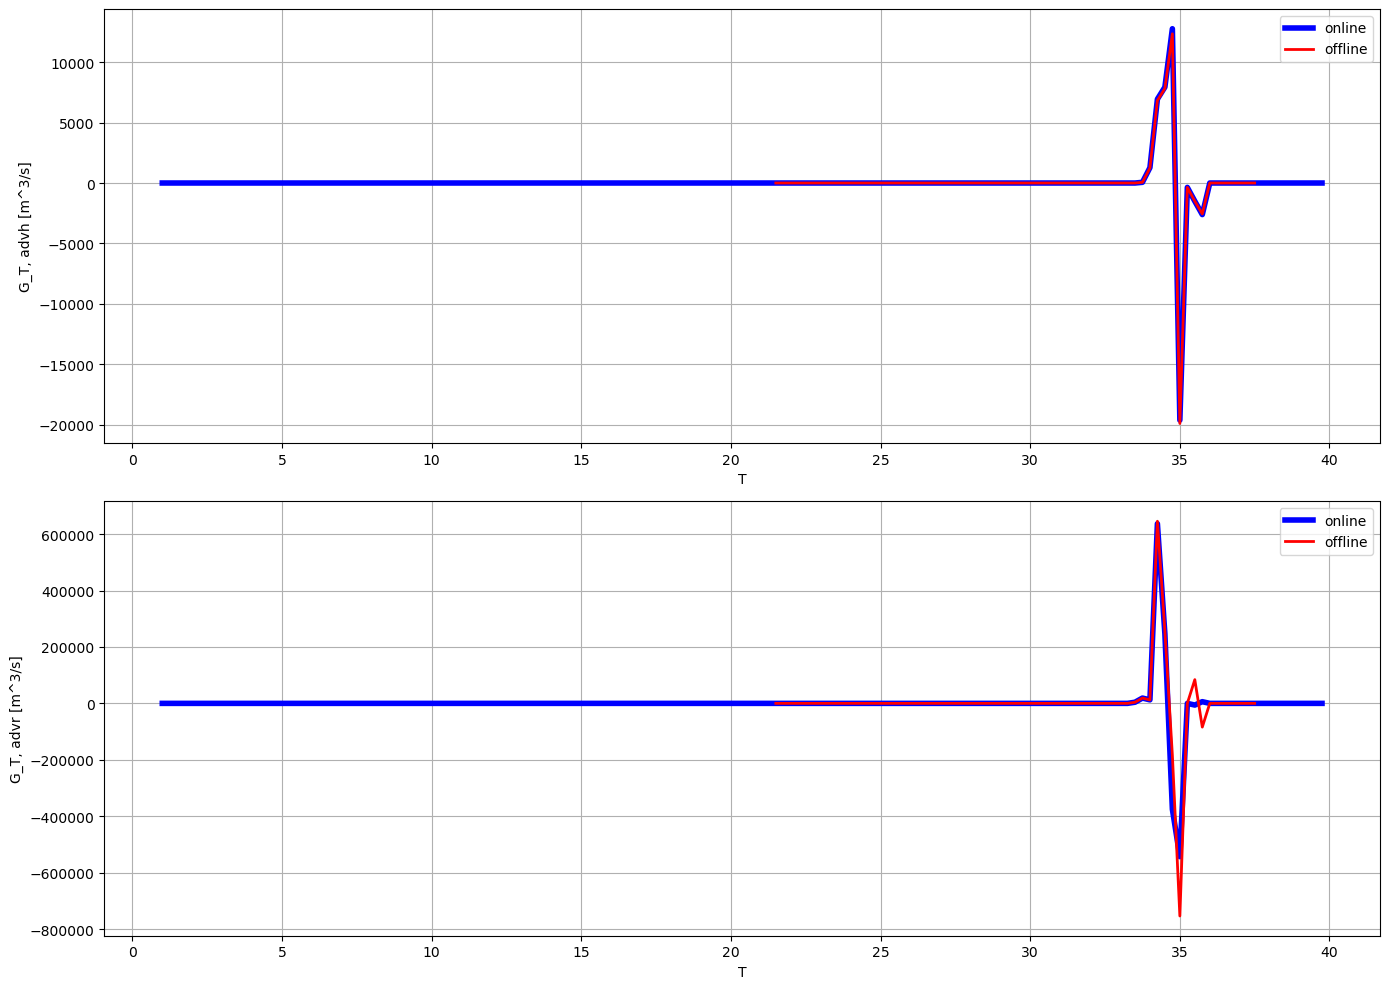

In [89]:
a = DFh*mymsk3d
a[np.isnan(a)] = 0
b = DFr*mymsk3d
b[np.isnan(b)] = 0
plot_figure4_new(SALT, a, b, boundsS.flatten(), binmidS.flatten(), binwidthS1,
                               GDFh, GDFr, iiT=None)
plt.show()

In [95]:
# load the surface terms
# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)

# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)

In [98]:
RAC3 = np.tile(RAC[np.newaxis,:,:],(nz,1,1))

In [100]:
#print(trWtop.shape)
sptop = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
sptop = sptop * RAC3        # g/s

zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s

In [109]:
def surface_contrib_JT(zconv_top_salt, sptop, rho, fill_last=0.0):
    """
    zconv_top_heat: (ny, nx)
    swtop:          (nz, ny, nx)
    rcp:            scalar
    fill_last:      value for bottom slice (k = nz-1), usually 0.0 or np.nan
    returns:
      JsurfT:       (nz, ny, nx)  # Sv / PSU
    """
    nz, ny, nx = sptop.shape

    eS = zconv_top_salt.reshape(1, ny, nx)  # (1,ny,nx) for broadcast

    J = np.empty_like(sptop, dtype=float)

    # k = 0: (eT - fT[1]) / rcp / dT / dS * 1e-6
    J[0] = (eS[0] - sptop[1]) / rho if np.ndim(binwidthS)==0 else \
           (eS[0] - sptop[1]) / rho

    # 1 .. nz-2: -(fT[k+1]-fT[k]) / rcp / dT / dS * 1e-6
    J[1:nz] = -(sptop[1:nz] - sptop[0:nz-1]) / rho

    # bottom slice (k = nz-1): no k+1; choose your boundary convention
    J[-1] = fill_last
    return J

Ft_surftest = surface_contrib_JT(zconv_top_salt,sptop,myparms['rhoconst'])    # this is in PSU.m^3/s

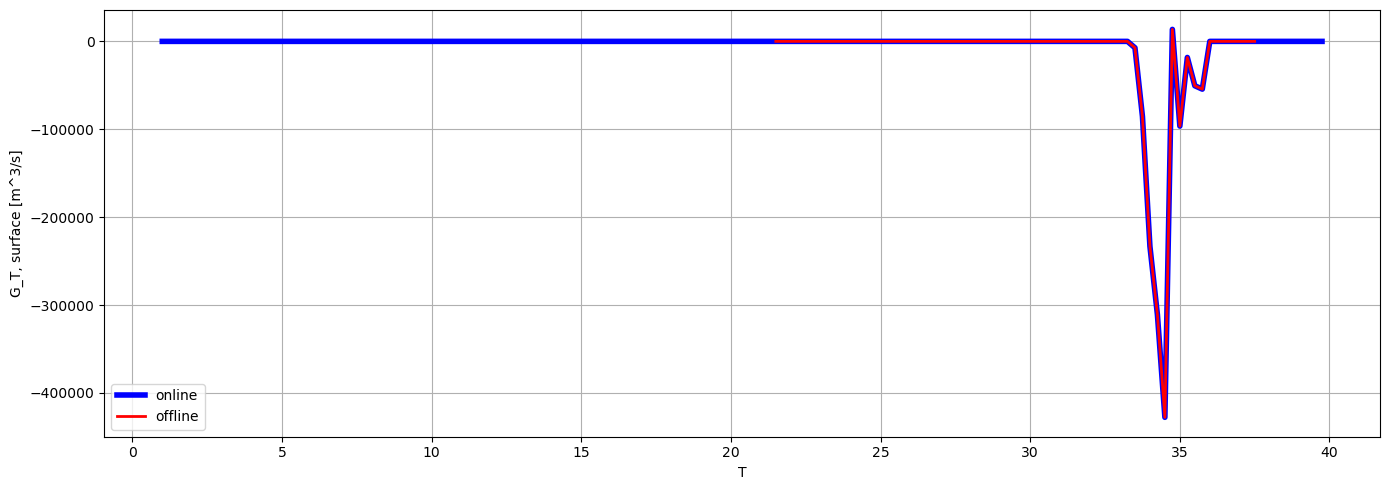

In [110]:
a = Ft_surftest*mymsk3d
a[np.isnan(a)] = 0

plot_figure4_1(SALT, a, b, boundsS.flatten(), binmidS.flatten(), binwidthS1,
                               Gsurf, GDFr, iiT=None)
plt.show()

In [111]:
# do the vertical convergence for KPP
trWtopKPP = -(KPPg_SLT)         # PSU.m^3/s

tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]

In [120]:
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisSALTDR,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt    # PSU.m/s
#print(np.nansum(SALTDR),dt)

tmptend = (SALTDR - 0) * mk3D_mod(RAC,SALTDR)    # PSU.m/s * m^2 = PSU.m^3/s

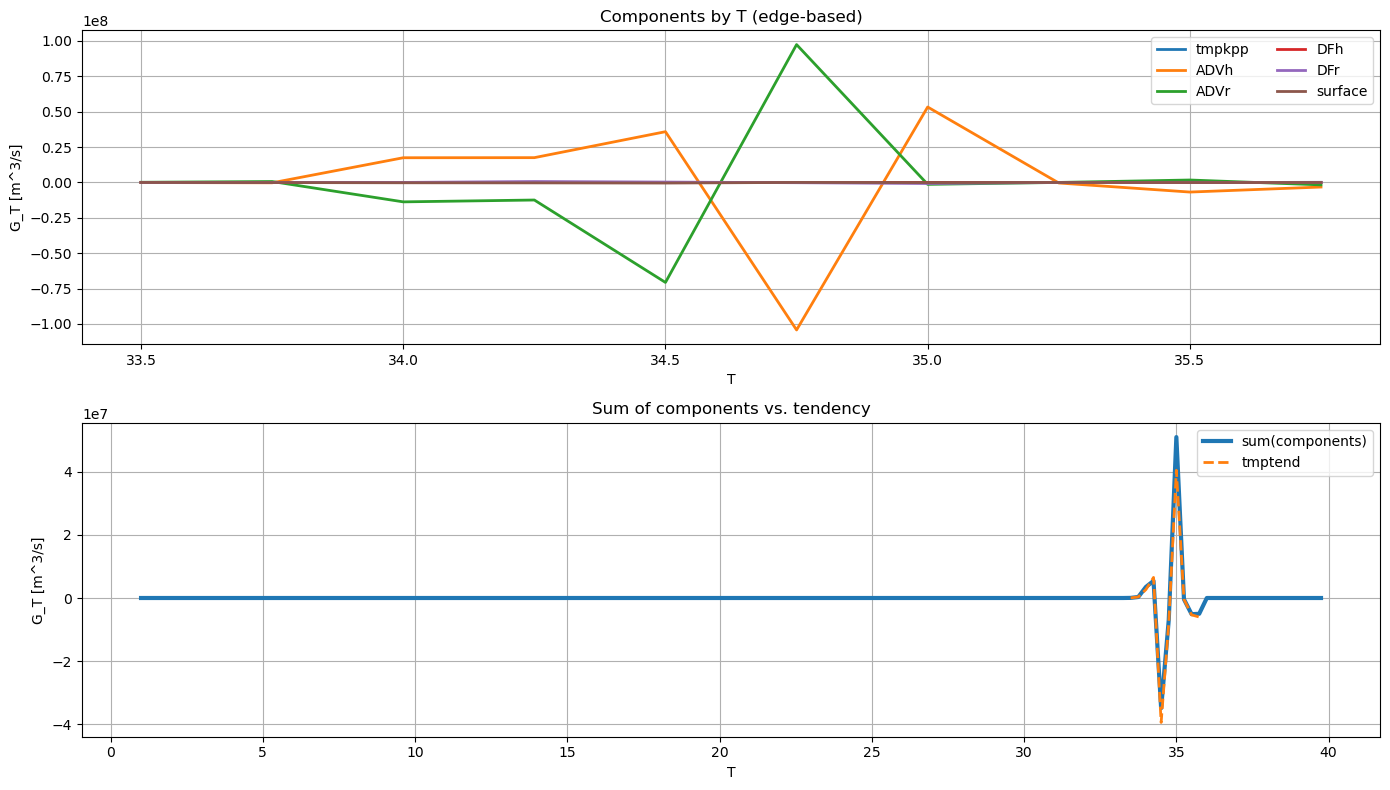

In [122]:
plot_figure4_components(
    SALT,
    boundsS.flatten(),
    binmidS.flatten(),
    binwidthS1.flatten(),
    mask=mymsk3d,                 # optional
    tendency_name="tmptend",      # change if your tendency is named differently
    tmpkpp=tmpkpp,
    ADVh=ADVh,
    ADVr=ADVr,
    DFh=DFh,
    DFr=DFr,
    surface=Ft_surftest,
    tmptend=tmptend*50,              # this will be the dashed curve on panel 2
)

In [123]:
# something is also wrong with our tendency calculation but it is the same shape. can we do the gateway terms here?